# Coupling

[x_global]   [cos(α_c)  -sin(α_c)  x_c] [x_local]
[y_global] = [sin(α_c)   cos(α_c)  y_c] [y_local]
[   1    ]   [   0          0       1 ] [   1   ]

Or more compactly:
$$
x_global = x_c + x_local * cos(α_c) - y_local * sin(α_c)
y_global = y_c + x_local * sin(α_c) + y_local * cos(α_c)
$$

## From Global to Local Coordinates

This is the inverse transformation. Given global coordinates (x_global, y_global), find local coordinates (x_local, y_local).

**Steps:**
1. Translate by -x_c, -y_c to move origin
2. Rotate by -α_c (inverse rotation)

**Matrix form:**

[x_local]   [cos(α_c)   sin(α_c)  -x_c*cos(α_c) - y_c*sin(α_c)] [x_global]
[y_local] = [-sin(α_c)  cos(α_c)  x_c*sin(α_c) - y_c*cos(α_c)] [y_global]
[   1   ]   [   0          0                1                 ] [   1   ]

Or in steps:
$$
dx = x_global - x_c
dy = y_global - y_c

x_local = dx * cos(α_c) + dy * sin(α_c)
y_local = -dx * sin(α_c) + dy * cos(α_c)
$$

In [24]:



# Transformation matrix: Local → Global
def local_to_global_matrix(x_c, y_c, alpha_c):
    c, s = np.cos(alpha_c), np.sin(alpha_c)
    return np.array([
        [c, -s, x_c],
        [s, c, y_c],
        [0, 0, 1]
    ])


# Transformation matrix: Global → Local
def global_to_local_matrix(x_c, y_c, alpha_c):
    c, s = np.cos(alpha_c), np.sin(alpha_c)
    return np.array([
        [c, s, -x_c * c - y_c * s],
        [-s, c, x_c * s - y_c * c],
        [0, 0, 1]
    ])


# Apply to multiple points (each column is a point)
# points shape: (2, N) for N points
def transform_points(points, T):
    homogeneous = np.vstack([points, np.ones((1, points.shape[1]))])
    transformed = T @ homogeneous
    return transformed[:2, :]

## Key Differences Summary

| Aspect | Rigid Block | Finite Element |
|--------|-------------|----------------|
| **Total DOFs** | 3 | 6 (triangle), 8 (quad) |
| **Deformation** | ❌ NO | ✅ YES |
| **Strain** | Always zero | Can be non-zero |
| **Kinematics** | u + R(θ)·x₀ | Σ Nᵢ·uᵢ (interpolation) |
| **Nodes** | All move identically | Each moves independently |
| **Use case** | Blocks, contact | Continuum, structures |

## Rigid Body Modes in FE

Interestingly, finite elements **can represent rigid body motion** as a special case when all nodes move in a coordinated way. This happens when:
For translation: u₁ = u₂ = u₃ = ... = u
                 v₁ = v₂ = v₃ = ... = v

For rotation: Nodal displacements follow rigid rotation pattern

In [25]:
import matplotlib.pyplot as plt
import numpy as np


# ============================================================================
# RIGID BLOCK CLASS (from before)
# ============================================================================
class RigidBlock2D:
    """2D Rigid Block with 3 DOFs"""

    def __init__(self, vertices_local):
        self.vertices_local = np.array(vertices_local)
        self.q = np.array([0.0, 0.0, 0.0])  # [u, v, theta]

    def rotation_matrix(self, theta):
        c, s = np.cos(theta), np.sin(theta)
        return np.array([[c, -s], [s, c]])

    def local_to_global(self, points_local):
        u, v, theta = self.q
        R = self.rotation_matrix(theta)
        if points_local.ndim == 1:
            points_local = points_local.reshape(1, -1)
        return np.array([u, v]) + (R @ points_local.T).T

    def set_configuration(self, u, v, theta):
        self.q = np.array([u, v, theta])

    def get_vertices_global(self):
        return self.local_to_global(self.vertices_local)


# ============================================================================
# FINITE ELEMENT CLASS
# ============================================================================
class TriangleElement:
    """Linear triangular finite element (T3) with 6 DOFs"""

    def __init__(self, nodes_initial):
        """
        nodes_initial: 3x2 array of initial nodal coordinates
                      [[x1, y1], [x2, y2], [x3, y3]]
        """
        self.nodes_initial = np.array(nodes_initial)
        self.n_nodes = 3
        self.n_dofs = 6  # 3 nodes × 2 DOFs/node

        # DOF vector: [u1, v1, u2, v2, u3, v3]
        self.q = np.zeros(6)

    def shape_functions(self, xi, eta):
        """
        Shape functions for linear triangle
        xi, eta: natural coordinates (0 ≤ xi, eta, xi+eta ≤ 1)
        """
        N1 = 1 - xi - eta
        N2 = xi
        N3 = eta
        return np.array([N1, N2, N3])

    def interpolate_displacement(self, xi, eta):
        """
        Interpolate displacement at any point (xi, eta)
        """
        N = self.shape_functions(xi, eta)

        # u = N1*u1 + N2*u2 + N3*u3
        u = N[0] * self.q[0] + N[1] * self.q[2] + N[2] * self.q[4]
        v = N[0] * self.q[1] + N[1] * self.q[3] + N[2] * self.q[5]

        return np.array([u, v])

    def interpolate_position(self, xi, eta):
        """
        Get current position at any point (xi, eta)
        Current position = Initial position + Displacement
        """
        N = self.shape_functions(xi, eta)

        # Initial position
        x0 = N @ self.nodes_initial[:, 0]
        y0 = N @ self.nodes_initial[:, 1]

        # Displacement
        u, v = self.interpolate_displacement(xi, eta)

        return np.array([x0 + u, y0 + v])

    def set_nodal_displacements(self, u1, v1, u2, v2, u3, v3):
        """Set all 6 DOFs"""
        self.q = np.array([u1, v1, u2, v2, u3, v3])

    def get_current_nodes(self):
        """Get current nodal positions (initial + displacement)"""
        current = self.nodes_initial.copy()
        current[0] += [self.q[0], self.q[1]]  # Node 1
        current[1] += [self.q[2], self.q[3]]  # Node 2
        current[2] += [self.q[4], self.q[5]]  # Node 3
        return current

    def compute_strain(self):
        """
        Compute strain in the element (constant for linear triangle)
        Returns: [εxx, εyy, γxy]
        """
        # For linear triangle, strain is constant
        # We need B matrix (strain-displacement)
        nodes = self.nodes_initial

        # Shape function derivatives (constant for linear triangle)
        x1, y1 = nodes[0]
        x2, y2 = nodes[1]
        x3, y3 = nodes[2]

        A = 0.5 * abs((x2 - x1) * (y3 - y1) - (x3 - x1) * (y2 - y1))  # Area

        # B matrix coefficients
        b1 = y2 - y3
        b2 = y3 - y1
        b3 = y1 - y2
        c1 = x3 - x2
        c2 = x1 - x3
        c3 = x2 - x1

        # B matrix
        B = (1 / (2 * A)) * np.array([
            [b1, 0, b2, 0, b3, 0],
            [0, c1, 0, c2, 0, c3],
            [c1, b1, c2, b2, c3, b3]
        ])

        # Strain = B * q
        strain = B @ self.q
        return strain


class QuadElement:
    """Bilinear quadrilateral element (Q4) with 8 DOFs"""

    def __init__(self, nodes_initial):
        """
        nodes_initial: 4x2 array of initial nodal coordinates
        """
        self.nodes_initial = np.array(nodes_initial)
        self.n_nodes = 4
        self.n_dofs = 8  # 4 nodes × 2 DOFs/node

        # DOF vector: [u1, v1, u2, v2, u3, v3, u4, v4]
        self.q = np.zeros(8)

    def shape_functions(self, xi, eta):
        """Shape functions for bilinear quad"""
        N = np.array([
            0.25 * (1 - xi) * (1 - eta),
            0.25 * (1 + xi) * (1 - eta),
            0.25 * (1 + xi) * (1 + eta),
            0.25 * (1 - xi) * (1 + eta)
        ])
        return N

    def interpolate_displacement(self, xi, eta):
        """Interpolate displacement at (xi, eta)"""
        N = self.shape_functions(xi, eta)

        u = sum(N[i] * self.q[2 * i] for i in range(4))
        v = sum(N[i] * self.q[2 * i + 1] for i in range(4))

        return np.array([u, v])

    def interpolate_position(self, xi, eta):
        """Get current position at (xi, eta)"""
        N = self.shape_functions(xi, eta)

        x0 = N @ self.nodes_initial[:, 0]
        y0 = N @ self.nodes_initial[:, 1]

        u, v = self.interpolate_displacement(xi, eta)

        return np.array([x0 + u, y0 + v])

    def set_nodal_displacements(self, *displacements):
        """Set all 8 DOFs"""
        self.q = np.array(displacements)

    def get_current_nodes(self):
        """Get current nodal positions"""
        current = self.nodes_initial.copy()
        for i in range(4):
            current[i] += [self.q[2 * i], self.q[2 * i + 1]]
        return current


COMPARISON: RIGID BLOCK vs FINITE ELEMENT

--- SCENARIO 1: Pure Translation ---
Triangle strain: [0. 0. 0.]
-> All elements behave identically (rigid body motion)

--- SCENARIO 2: Pure Rotation ---
Triangle strain: [-1.33974596e-01 -1.33974596e-01  3.88578059e-16]
-> All elements behave identically (rigid body motion)

--- SCENARIO 3: Deformation (DIFFERENT!) ---
Triangle strain: εxx=0.2000, εyy=0.0000, γxy=0.0000
-> Finite elements CAN deform, rigid blocks CANNOT!

--- SCENARIO 4: Shear Deformation ---
Triangle strain: εxx=0.0000, εyy=0.0000, γxy=0.1500

--- SCENARIO 5: Bending-like Deformation ---


C:\Users\thleg\AppData\Local\Temp\ipykernel_22492\163662751.py:135: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[0, 2].plot(*np.vstack([rigid_verts, rigid_verts[0]]).T, 'b-', linewidth=2,



Figure saved as 'rigid_vs_fe_comparison.png'


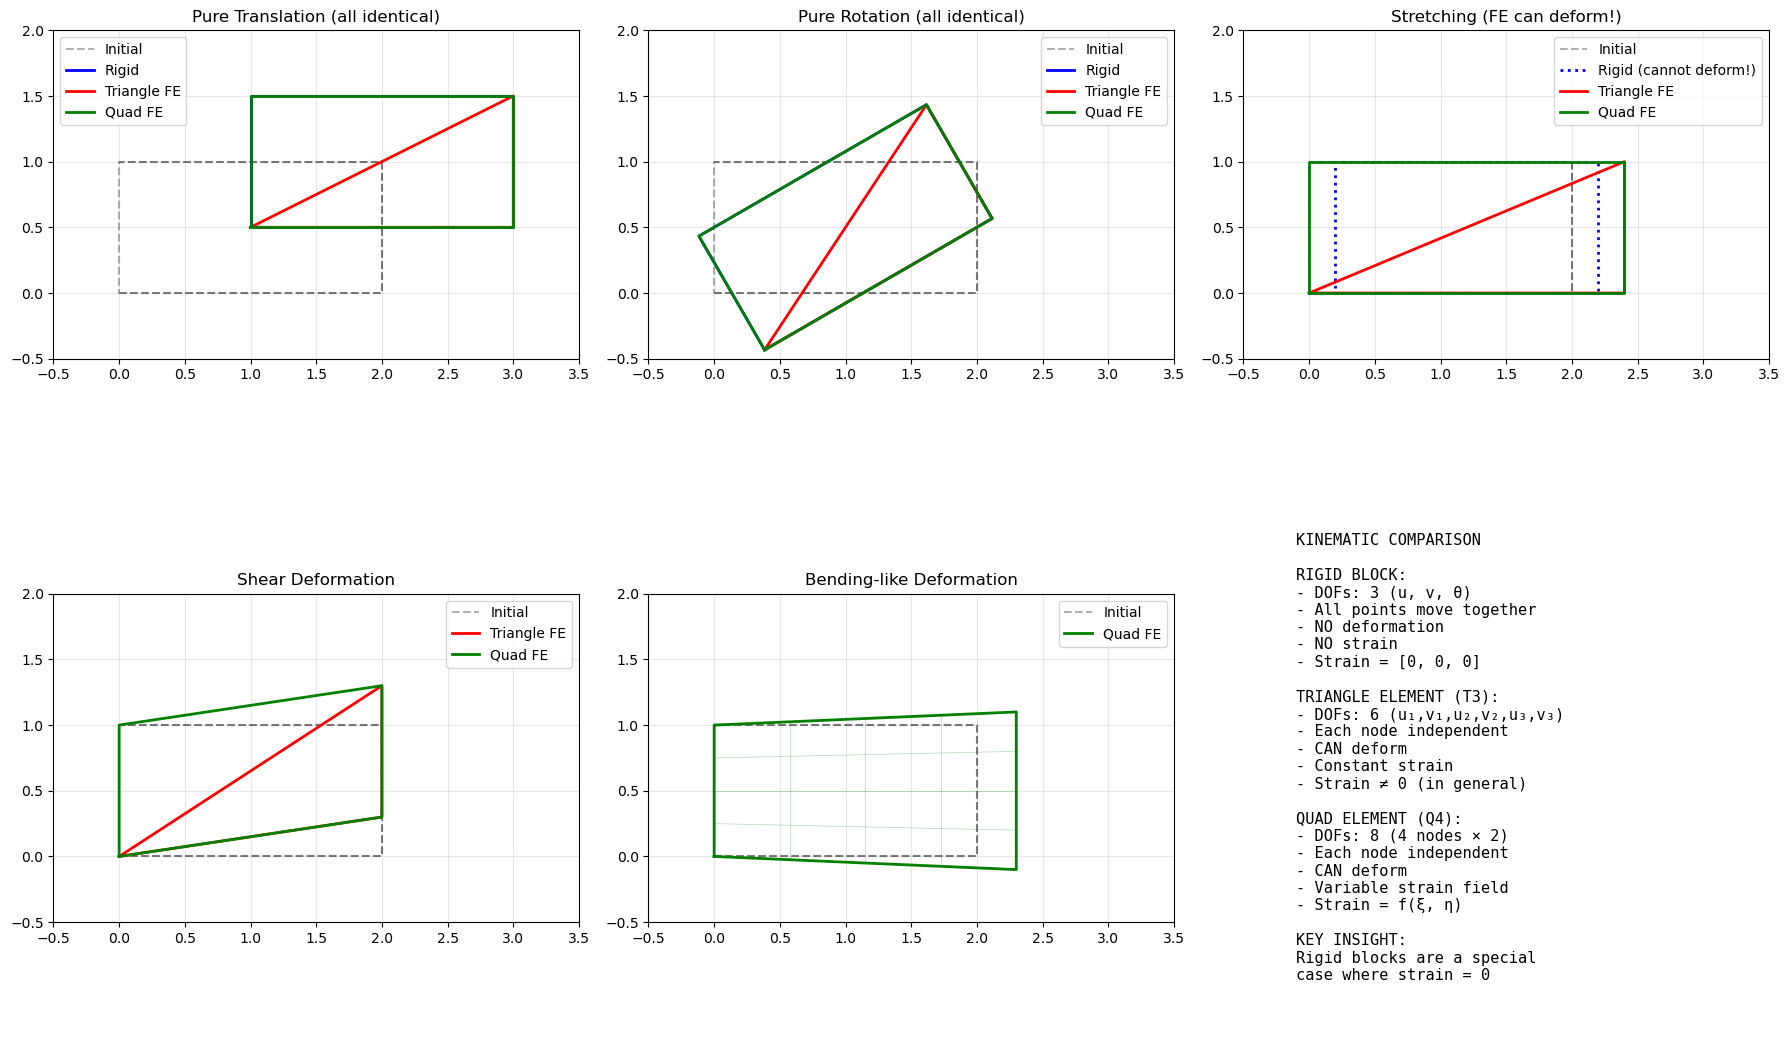

In [26]:

# ============================================================================
# VISUALIZATION AND COMPARISON
# ============================================================================

print("=" * 70)
print("COMPARISON: RIGID BLOCK vs FINITE ELEMENT")
print("=" * 70)

# Define initial geometry (same for all)
initial_vertices = np.array([
    [0.0, 0.0],
    [2.0, 0.0],
    [2.0, 1.0],
    [0.0, 1.0]
])

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ============================================================================
# SCENARIO 1: Pure Translation
# ============================================================================
print("\n--- SCENARIO 1: Pure Translation ---")

# Rigid block
rigid1 = RigidBlock2D(initial_vertices)
rigid1.set_configuration(1.0, 0.5, 0.0)  # u=1, v=0.5, theta=0

# Triangle element (split quad into 2 triangles, use first one)
tri_nodes = initial_vertices[:3]
tri1 = TriangleElement(tri_nodes)
tri1.set_nodal_displacements(1.0, 0.5, 1.0, 0.5, 1.0, 0.5)  # All nodes move same

# Quad element
quad1 = QuadElement(initial_vertices)
quad1.set_nodal_displacements(1.0, 0.5, 1.0, 0.5, 1.0, 0.5, 1.0, 0.5)

# Plot
axes[0, 0].plot(*initial_vertices.T, 'k--', alpha=0.3, label='Initial')
axes[0, 0].plot(*np.vstack([initial_vertices, initial_vertices[0]]).T, 'k--', alpha=0.3)

rigid_verts = rigid1.get_vertices_global()
axes[0, 0].plot(*np.vstack([rigid_verts, rigid_verts[0]]).T, 'b-', linewidth=2, label='Rigid')

tri_verts = tri1.get_current_nodes()
axes[0, 0].plot(*np.vstack([tri_verts, tri_verts[0]]).T, 'r-', linewidth=2, label='Triangle FE')

quad_verts = quad1.get_current_nodes()
axes[0, 0].plot(*np.vstack([quad_verts, quad_verts[0]]).T, 'g-', linewidth=2, label='Quad FE')

axes[0, 0].set_aspect('equal')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_title('Pure Translation (all identical)')
axes[0, 0].set_xlim(-0.5, 3.5)
axes[0, 0].set_ylim(-0.5, 2)

print("Triangle strain:", tri1.compute_strain())
print("-> All elements behave identically (rigid body motion)")

# ============================================================================
# SCENARIO 2: Pure Rotation
# ============================================================================
print("\n--- SCENARIO 2: Pure Rotation ---")

# Rigid block - rotate 30 degrees about centroid
rigid2 = RigidBlock2D(initial_vertices - [1, 0.5])  # Center at origin
rigid2.set_configuration(1.0, 0.5, np.pi / 6)

# For FE to represent pure rotation, need to calculate nodal displacements
angle = np.pi / 6
center = np.array([1.0, 0.5])
R = np.array([[np.cos(angle), -np.sin(angle)],
              [np.sin(angle), np.cos(angle)]])

tri_nodes = initial_vertices[:3]
tri2 = TriangleElement(tri_nodes)
tri_disp = []
for node in tri_nodes:
    rotated = center + R @ (node - center)
    tri_disp.extend(rotated - node)
tri2.set_nodal_displacements(*tri_disp)

quad2 = QuadElement(initial_vertices)
quad_disp = []
for node in initial_vertices:
    rotated = center + R @ (node - center)
    quad_disp.extend(rotated - node)
quad2.set_nodal_displacements(*quad_disp)

# Plot
axes[0, 1].plot(*initial_vertices.T, 'k--', alpha=0.3, label='Initial')
axes[0, 1].plot(*np.vstack([initial_vertices, initial_vertices[0]]).T, 'k--', alpha=0.3)

rigid_verts = rigid2.get_vertices_global()
axes[0, 1].plot(*np.vstack([rigid_verts, rigid_verts[0]]).T, 'b-', linewidth=2, label='Rigid')

tri_verts = tri2.get_current_nodes()
axes[0, 1].plot(*np.vstack([tri_verts, tri_verts[0]]).T, 'r-', linewidth=2, label='Triangle FE')

quad_verts = quad2.get_current_nodes()
axes[0, 1].plot(*np.vstack([quad_verts, quad_verts[0]]).T, 'g-', linewidth=2, label='Quad FE')

axes[0, 1].set_aspect('equal')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].set_title('Pure Rotation (all identical)')
axes[0, 1].set_xlim(-0.5, 3.5)
axes[0, 1].set_ylim(-0.5, 2)

print("Triangle strain:", tri2.compute_strain())
print("-> All elements behave identically (rigid body motion)")

# ============================================================================
# SCENARIO 3: Deformation (FE can deform, rigid cannot!)
# ============================================================================
print("\n--- SCENARIO 3: Deformation (DIFFERENT!) ---")

# Rigid block - cannot deform! Must choose some representative motion
rigid3 = RigidBlock2D(initial_vertices)
rigid3.set_configuration(0.2, 0, 0)  # Some average motion

# Triangle - stretch in x direction
tri3 = TriangleElement(tri_nodes)
tri3.set_nodal_displacements(0, 0, 0.4, 0, 0.4, 0)  # Stretch right nodes

# Quad - stretch in x direction
quad3 = QuadElement(initial_vertices)
quad3.set_nodal_displacements(0, 0, 0.4, 0, 0.4, 0, 0, 0)

# Plot
axes[0, 2].plot(*initial_vertices.T, 'k--', alpha=0.3, label='Initial')
axes[0, 2].plot(*np.vstack([initial_vertices, initial_vertices[0]]).T, 'k--', alpha=0.3)

rigid_verts = rigid3.get_vertices_global()
axes[0, 2].plot(*np.vstack([rigid_verts, rigid_verts[0]]).T, 'b-', linewidth=2,
                label='Rigid (cannot deform!)', linestyle='dotted')

tri_verts = tri3.get_current_nodes()
axes[0, 2].plot(*np.vstack([tri_verts, tri_verts[0]]).T, 'r-', linewidth=2, label='Triangle FE')

quad_verts = quad3.get_current_nodes()
axes[0, 2].plot(*np.vstack([quad_verts, quad_verts[0]]).T, 'g-', linewidth=2, label='Quad FE')

axes[0, 2].set_aspect('equal')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].legend()
axes[0, 2].set_title('Stretching (FE can deform!)')
axes[0, 2].set_xlim(-0.5, 3.5)
axes[0, 2].set_ylim(-0.5, 2)

strain_tri = tri3.compute_strain()
print(f"Triangle strain: εxx={strain_tri[0]:.4f}, εyy={strain_tri[1]:.4f}, γxy={strain_tri[2]:.4f}")
print("-> Finite elements CAN deform, rigid blocks CANNOT!")

# ============================================================================
# SCENARIO 4: Shear Deformation
# ============================================================================
print("\n--- SCENARIO 4: Shear Deformation ---")

tri4 = TriangleElement(tri_nodes)
tri4.set_nodal_displacements(0, 0, 0, 0.3, 0, 0.3)  # Shear

quad4 = QuadElement(initial_vertices)
quad4.set_nodal_displacements(0, 0, 0, 0.3, 0, 0.3, 0, 0)

# Plot
axes[1, 0].plot(*initial_vertices.T, 'k--', alpha=0.3, label='Initial')
axes[1, 0].plot(*np.vstack([initial_vertices, initial_vertices[0]]).T, 'k--', alpha=0.3)

tri_verts = tri4.get_current_nodes()
axes[1, 0].plot(*np.vstack([tri_verts, tri_verts[0]]).T, 'r-', linewidth=2, label='Triangle FE')

quad_verts = quad4.get_current_nodes()
axes[1, 0].plot(*np.vstack([quad_verts, quad_verts[0]]).T, 'g-', linewidth=2, label='Quad FE')

axes[1, 0].set_aspect('equal')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_title('Shear Deformation')
axes[1, 0].set_xlim(-0.5, 3.5)
axes[1, 0].set_ylim(-0.5, 2)

strain_tri = tri4.compute_strain()
print(f"Triangle strain: εxx={strain_tri[0]:.4f}, εyy={strain_tri[1]:.4f}, γxy={strain_tri[2]:.4f}")

# ============================================================================
# SCENARIO 5: Bending-like deformation
# ============================================================================
print("\n--- SCENARIO 5: Bending-like Deformation ---")

quad5 = QuadElement(initial_vertices)
quad5.set_nodal_displacements(0, 0, 0.3, -0.1, 0.3, 0.1, 0, 0)

# Plot
axes[1, 1].plot(*initial_vertices.T, 'k--', alpha=0.3, label='Initial')
axes[1, 1].plot(*np.vstack([initial_vertices, initial_vertices[0]]).T, 'k--', alpha=0.3)

quad_verts = quad5.get_current_nodes()
axes[1, 1].plot(*np.vstack([quad_verts, quad_verts[0]]).T, 'g-', linewidth=2, label='Quad FE')

# Show deformed shape with grid
xi_vals = np.linspace(-1, 1, 5)
eta_vals = np.linspace(-1, 1, 5)
for xi in xi_vals:
    line = [quad5.interpolate_position(xi, eta) for eta in np.linspace(-1, 1, 20)]
    line = np.array(line)
    axes[1, 1].plot(line[:, 0], line[:, 1], 'g-', alpha=0.3, linewidth=0.5)
for eta in eta_vals:
    line = [quad5.interpolate_position(xi, eta) for xi in np.linspace(-1, 1, 20)]
    line = np.array(line)
    axes[1, 1].plot(line[:, 0], line[:, 1], 'g-', alpha=0.3, linewidth=0.5)

axes[1, 1].set_aspect('equal')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].set_title('Bending-like Deformation')
axes[1, 1].set_xlim(-0.5, 3.5)
axes[1, 1].set_ylim(-0.5, 2)

# ============================================================================
# Summary table
# ============================================================================
axes[1, 2].axis('off')
summary_text = """
KINEMATIC COMPARISON

RIGID BLOCK:
- DOFs: 3 (u, v, θ)
- All points move together
- NO deformation
- NO strain
- Strain = [0, 0, 0]

TRIANGLE ELEMENT (T3):
- DOFs: 6 (u₁,v₁,u₂,v₂,u₃,v₃)
- Each node independent
- CAN deform
- Constant strain
- Strain ≠ 0 (in general)

QUAD ELEMENT (Q4):
- DOFs: 8 (4 nodes × 2)
- Each node independent
- CAN deform
- Variable strain field
- Strain = f(ξ, η)

KEY INSIGHT:
Rigid blocks are a special
case where strain = 0
"""
axes[1, 2].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.savefig('out/rigid_vs_fe_comparison.png', dpi=150, bbox_inches='tight')
print("\nFigure saved as 'rigid_vs_fe_comparison.png'")

## Key Concepts Implemented

### 1. **Constraint Equations**
For a node on the interface at position (x, y):
```
u_node = u_block - (y - y_c) · θ_block
v_node = v_block + (x - x_c) · θ_block
```

### 2. **Transformation Matrix T**
Maps reduced DOFs to full DOFs:
```
u_full = T · u_reduced
```

For fixed block (2 free DOFs):
```
T = [0  0]    ← Node 0: u
    [0  0]    ← Node 0: v
    [0  0]    ← Node 1: u
    [0  0]    ← Node 1: v
    [1  0]    ← Node 2: u (free)
    [0  1]    ← Node 2: v (free)
```

For movable block (5 DOFs):
```
T = [1  0  -(y₀-y_c)  0  0]    ← Node 0: u
    [0  1   (x₀-x_c)  0  0]    ← Node 0: v
    [1  0  -(y₁-y_c)  0  0]    ← Node 1: u
    [0  1   (x₁-x_c)  0  0]    ← Node 1: v
    [0  0      0      1  0]    ← Node 2: u (free)
    [0  0      0      0  1]    ← Node 2: v (free)
```

### 3. **System Reduction**
```
K_reduced = T^T · K_full · T
F_reduced = T^T · F_full

## More general coupling

In [27]:
from scipy.sparse import lil_matrix
from matplotlib.patches import Arc


# ============================================================================
# TRIANGLE ELEMENT CLASS (Kept as original)
# ============================================================================
class TriangleElement:
    """Linear triangular element for 2D elasticity"""

    def __init__(self, nodes, E=1000.0, nu=0.3, thickness=1.0):
        """
        nodes: 3x2 array [[x1,y1], [x2,y2], [x3,y3]]
        E: Young's modulus
        nu: Poisson's ratio
        thickness: element thickness
        """
        self.nodes = np.array(nodes, dtype=float)
        self.E = E
        self.nu = nu
        self.t = thickness

        # Compute element properties
        self.area = self.compute_area()
        self.D = self.constitutive_matrix()
        self.K = self.stiffness_matrix()

    def compute_area(self):
        """Compute element area"""
        x = self.nodes[:, 0]
        y = self.nodes[:, 1]
        return 0.5 * abs((x[1] - x[0]) * (y[2] - y[0]) - (x[2] - x[0]) * (y[1] - y[0]))

    def constitutive_matrix(self):
        """Plane stress constitutive matrix"""
        E = self.E
        nu = self.nu
        factor = E / (1 - nu ** 2)

        D = factor * np.array([
            [1, nu, 0],
            [nu, 1, 0],
            [0, 0, (1 - nu) / 2]
        ])
        return D

    def B_matrix(self):
        """Strain-displacement matrix (constant for linear triangle)"""
        x = self.nodes[:, 0]
        y = self.nodes[:, 1]

        # Shape function derivatives
        b = np.array([y[1] - y[2], y[2] - y[0], y[0] - y[1]])
        c = np.array([x[2] - x[1], x[0] - x[2], x[1] - x[0]])

        # B matrix (3x6)
        B = np.zeros((3, 6))
        for i in range(3):
            B[0, 2 * i] = b[i]  # ∂Ni/∂x contributes to εxx
            B[1, 2 * i + 1] = c[i]  # ∂Ni/∂y contributes to εyy
            B[2, 2 * i] = c[i]  # ∂Ni/∂y contributes to γxy
            B[2, 2 * i + 1] = b[i]  # ∂Ni/∂x contributes to γxy

        B = B / (2 * self.area)
        return B

    def stiffness_matrix(self):
        """Element stiffness matrix (6x6): K = B^T * D * B * A * t"""
        B = self.B_matrix()
        K = B.T @ self.D @ B * self.area * self.t
        return K

    def compute_stress(self, u):
        """Compute stress from displacement vector"""
        B = self.B_matrix()
        strain = B @ u  # ε = B * u
        stress = self.D @ strain  # σ = D * ε
        return stress, strain

    def compute_nodal_forces(self, u):
        """Compute internal nodal forces from displacements"""
        return self.K @ u


# ============================================================================
# RIGID BLOCK CLASS (Kept as original)
# ============================================================================
class RigidBlock2D:
    """2D Rigid block with 3 DOFs: u, v, θ"""

    def __init__(self, reference_point, name=None):
        """
        reference_point: [x_c, y_c] - reference point for the block
        name: optional identifier for the block
        """
        self.ref_point = np.array(reference_point, dtype=float)
        self.q = np.array([0.0, 0.0, 0.0])  # [u, v, θ]
        self.fixed_dofs = []
        self.name = name

    def set_fixed(self, dofs='all'):
        """Fix specific DOFs of the rigid block"""
        if dofs == 'all':
            self.fixed_dofs = [0, 1, 2]
        elif dofs == 'horizontal':
            self.fixed_dofs = [0, 2]
        elif dofs == 'vertical':
            self.fixed_dofs = [1]
        elif dofs == 'rotation':
            self.fixed_dofs = [2]
        elif isinstance(dofs, list):
            self.fixed_dofs = dofs
        else:
            self.fixed_dofs = []

        for dof in self.fixed_dofs:
            self.q[dof] = 0.0

    def get_free_dofs(self):
        """Get list of free DOF indices"""
        all_dofs = {0, 1, 2}
        return sorted(list(all_dofs - set(self.fixed_dofs)))

    def is_fully_fixed(self):
        """Check if all DOFs are fixed"""
        return len(self.fixed_dofs) == 3

    def constraint_matrix_for_node(self, node_position):
        """
        Get constraint matrix C such that: [u_node, v_node] = C * [u_b, v_b, θ_b]
        Returns 2x3 matrix
        """
        x, y = node_position
        x_c, y_c = self.ref_point

        C = np.array([
            [1, 0, -(y - y_c)],
            [0, 1, (x - x_c)]
        ])

        return C


# ============================================================================
# GENERALIZED COUPLED SYSTEM
# ============================================================================
class GeneralizedCoupledSystem:
    """
    Generalized system that can handle:
    - Multiple FEM elements connected to each other
    - Multiple rigid blocks
    - Connections between FEM nodes and rigid blocks
    """

    def __init__(self, verbose=True):
        """Initialize empty system"""
        self.verbose = verbose

        # Storage for components
        self.fem_elements = []  # List of TriangleElement objects
        self.rigid_blocks = []  # List of RigidBlock2D objects

        # Global node management
        self.node_positions = {}  # {node_id: [x, y]}
        self.next_node_id = 0

        # Connectivity
        self.element_connectivity = []  # List of [elem_id, [node_id1, node_id2, node_id3]]
        self.rigid_connections = []  # List of [block_id, node_id]

        # DOF management
        self.node_to_dofs = {}  # {node_id: [dof_u, dof_v]}
        self.block_to_dofs = {}  # {block_id: [dof_u, dof_v, dof_theta]}
        self.total_dofs = 0

        # System matrices
        self.K_global = None
        self.F_global = None

        # Constraint information
        self.constrained_nodes = set()  # Nodes connected to rigid blocks

    def add_node(self, position, node_id=None):
        """
        Add a node to the system

        Parameters:
        -----------
        position : array-like
            [x, y] coordinates
        node_id : int, optional
            Specific node ID (if None, auto-assigned)

        Returns:
        --------
        node_id : int
        """
        if node_id is None:
            node_id = self.next_node_id
            self.next_node_id += 1
        else:
            self.next_node_id = max(self.next_node_id, node_id + 1)

        self.node_positions[node_id] = np.array(position, dtype=float)
        return node_id

    def add_fem_element(self, node_ids, E=1000.0, nu=0.3, thickness=1.0):
        """
        Add a FEM element

        Parameters:
        -----------
        node_ids : list
            List of 3 node IDs that form the triangle
        E, nu, thickness : material properties

        Returns:
        --------
        elem_id : int
        """
        # Get node positions
        nodes = [self.node_positions[nid] for nid in node_ids]

        # Create element
        elem = TriangleElement(nodes, E, nu, thickness)
        elem_id = len(self.fem_elements)
        self.fem_elements.append(elem)

        # Store connectivity
        self.element_connectivity.append([elem_id, node_ids])

        if self.verbose:
            print(f"Added FEM element {elem_id} with nodes {node_ids}")

        return elem_id

    def add_rigid_block(self, reference_point, name=None):
        """
        Add a rigid block

        Parameters:
        -----------
        reference_point : array-like
            [x, y] reference point
        name : str, optional
            Block name

        Returns:
        --------
        block_id : int
        """
        block = RigidBlock2D(reference_point, name)
        block_id = len(self.rigid_blocks)
        self.rigid_blocks.append(block)

        if self.verbose:
            print(f"Added rigid block {block_id} at {reference_point}")

        return block_id

    def connect_node_to_block(self, node_id, block_id):
        """
        Connect a FEM node to a rigid block

        Parameters:
        -----------
        node_id : int
            Node ID
        block_id : int
            Block ID
        """
        self.rigid_connections.append([block_id, node_id])
        self.constrained_nodes.add(node_id)

        if self.verbose:
            print(f"Connected node {node_id} to rigid block {block_id}")

    def build_dof_map(self):
        """
        Build global DOF mapping

        For each free node: 2 DOFs (u, v)
        For each rigid block: 3 DOFs (u, v, θ)
        Constrained nodes don't get their own DOFs (controlled by block DOFs)
        """
        dof_counter = 0

        # Assign DOFs to free nodes
        all_nodes = set(self.node_positions.keys())
        free_nodes = all_nodes - self.constrained_nodes

        for node_id in sorted(free_nodes):
            self.node_to_dofs[node_id] = [dof_counter, dof_counter + 1]
            dof_counter += 2

        # Assign DOFs to rigid blocks
        for block_id in range(len(self.rigid_blocks)):
            self.block_to_dofs[block_id] = [dof_counter, dof_counter + 1, dof_counter + 2]
            dof_counter += 3

        self.total_dofs = dof_counter

        if self.verbose:
            print(f"\nDOF mapping built:")
            print(f"  Free nodes: {len(free_nodes)} ({len(free_nodes) * 2} DOFs)")
            print(f"  Constrained nodes: {len(self.constrained_nodes)}")
            print(f"  Rigid blocks: {len(self.rigid_blocks)} ({len(self.rigid_blocks) * 3} DOFs)")
            print(f"  Total DOFs: {self.total_dofs}")

    def assemble_global_stiffness(self):
        """
        Assemble global stiffness matrix

        Strategy:
        1. Assemble FEM element contributions
        2. Apply rigid body constraints
        """
        self.K_global = lil_matrix((self.total_dofs, self.total_dofs))

        # Build node-to-block mapping for quick lookup
        node_to_block = {}
        for block_id, node_id in self.rigid_connections:
            node_to_block[node_id] = block_id

        # Process each FEM element
        for elem_id, node_ids in self.element_connectivity:
            elem = self.fem_elements[elem_id]
            K_elem = elem.K  # 6x6 element stiffness

            # Map element DOFs to global DOFs
            global_dofs = []
            constraint_matrices = []  # Store constraint matrices for constrained nodes

            for local_node_idx, node_id in enumerate(node_ids):
                if node_id in self.constrained_nodes:
                    # Node is connected to a rigid block
                    block_id = node_to_block[node_id]
                    block_dofs = self.block_to_dofs[block_id]
                    node_pos = self.node_positions[node_id]

                    # Get constraint matrix C: u_node = C * q_block
                    C = self.rigid_blocks[block_id].constraint_matrix_for_node(node_pos)

                    global_dofs.append((block_dofs, C))
                    constraint_matrices.append(C)
                else:
                    # Free node
                    node_dofs = self.node_to_dofs[node_id]
                    global_dofs.append((node_dofs, None))
                    constraint_matrices.append(None)

            # Assemble element stiffness into global matrix
            for i in range(3):  # Loop over element nodes
                for j in range(3):
                    # Extract 2x2 block from element stiffness
                    K_ij = K_elem[2 * i:2 * i + 2, 2 * j:2 * j + 2]

                    dofs_i, C_i = global_dofs[i]
                    dofs_j, C_j = global_dofs[j]

                    if C_i is None and C_j is None:
                        # Both nodes are free - direct assembly
                        self.K_global[np.ix_(dofs_i, dofs_j)] += K_ij

                    elif C_i is None and C_j is not None:
                        # i is free, j is constrained
                        # K_ij_transformed = K_ij @ C_j
                        K_transformed = K_ij @ C_j
                        self.K_global[np.ix_(dofs_i, dofs_j)] += K_transformed

                    elif C_i is not None and C_j is None:
                        # i is constrained, j is free
                        # K_ij_transformed = C_i.T @ K_ij
                        K_transformed = C_i.T @ K_ij
                        self.K_global[np.ix_(dofs_i, dofs_j)] += K_transformed

                    else:
                        # Both nodes are constrained
                        # K_ij_transformed = C_i.T @ K_ij @ C_j
                        K_transformed = C_i.T @ K_ij @ C_j
                        self.K_global[np.ix_(dofs_i, dofs_j)] += K_transformed

        # Convert to CSR format for efficient solving
        self.K_global = self.K_global.tocsr()

        if self.verbose:
            print(f"\nGlobal stiffness matrix assembled: {self.K_global.shape}")
            print(f"  Non-zero entries: {self.K_global.nnz}")

    def apply_boundary_conditions(self):
        """
        Apply boundary conditions (fixed DOFs of rigid blocks)

        Returns:
        --------
        free_dofs : list
            List of free DOF indices
        """
        fixed_dofs = set()

        # Collect fixed DOFs from rigid blocks
        for block_id, block in enumerate(self.rigid_blocks):
            block_dofs = self.block_to_dofs[block_id]
            for local_dof in block.fixed_dofs:
                global_dof = block_dofs[local_dof]
                fixed_dofs.add(global_dof)

        # Get free DOFs
        all_dofs = set(range(self.total_dofs))
        free_dofs = sorted(list(all_dofs - fixed_dofs))

        if self.verbose:
            print(f"\nBoundary conditions:")
            print(f"  Fixed DOFs: {len(fixed_dofs)}")
            print(f"  Free DOFs: {len(free_dofs)}")

        return free_dofs

    def solve(self, external_forces):
        """
        Solve the coupled system

        Parameters:
        -----------
        external_forces : dict
            {node_id: [Fx, Fy]} for forces on free nodes

        Returns:
        --------
        solution : dict
            {
                'node_displacements': {node_id: [u, v]},
                'block_displacements': {block_id: [u, v, theta]},
                'reactions': reaction information
            }
        """
        if self.verbose:
            print("\n" + "=" * 70)
            print("SOLVING COUPLED SYSTEM")
            print("=" * 70)

        # Build DOF map
        self.build_dof_map()

        # Assemble global stiffness
        self.assemble_global_stiffness()

        # Build force vector
        F_global = np.zeros(self.total_dofs)
        for node_id, force in external_forces.items():
            if node_id in self.node_to_dofs:  # Only apply to free nodes
                dofs = self.node_to_dofs[node_id]
                F_global[dofs[0]] = force[0]
                F_global[dofs[1]] = force[1]

        # Apply boundary conditions
        free_dofs = self.apply_boundary_conditions()

        # Reduce system
        K_reduced = self.K_global[np.ix_(free_dofs, free_dofs)].toarray()
        F_reduced = F_global[free_dofs]

        if self.verbose:
            print(f"\nReduced system size: {len(free_dofs)} x {len(free_dofs)}")
            print(f"Condition number: {np.linalg.cond(K_reduced):.2e}")

        # Solve
        u_reduced = np.linalg.solve(K_reduced, F_reduced)

        # Expand to full solution
        u_global = np.zeros(self.total_dofs)
        u_global[free_dofs] = u_reduced

        # Extract solution
        solution = self._extract_solution(u_global)

        # Compute reactions
        solution['reactions'] = self._compute_reactions(u_global, F_global)

        return solution

    def _extract_solution(self, u_global):
        """Extract solution from global displacement vector"""
        solution = {
            'node_displacements': {},
            'block_displacements': {},
            'u_global': u_global
        }

        # Free node displacements
        for node_id, dofs in self.node_to_dofs.items():
            solution['node_displacements'][node_id] = u_global[dofs]

        # Constrained node displacements (compute from rigid body motion)
        node_to_block = {node_id: block_id for block_id, node_id in self.rigid_connections}
        for node_id in self.constrained_nodes:
            block_id = node_to_block[node_id]
            block_dofs = self.block_to_dofs[block_id]
            q_block = u_global[block_dofs]

            # Compute node displacement from rigid body motion
            C = self.rigid_blocks[block_id].constraint_matrix_for_node(
                self.node_positions[node_id]
            )
            u_node = C @ q_block
            solution['node_displacements'][node_id] = u_node

        # Block displacements
        for block_id, dofs in self.block_to_dofs.items():
            solution['block_displacements'][block_id] = u_global[dofs]

        if self.verbose:
            print("\n" + "=" * 70)
            print("SOLUTION")
            print("=" * 70)
            for node_id in sorted(solution['node_displacements'].keys()):
                u = solution['node_displacements'][node_id]
                constrained = " (constrained)" if node_id in self.constrained_nodes else ""
                print(f"Node {node_id}{constrained}: u={u[0]:8.4f}, v={u[1]:8.4f}")

            for block_id in sorted(solution['block_displacements'].keys()):
                q = solution['block_displacements'][block_id]
                print(f"Block {block_id}: u={q[0]:8.4f}, v={q[1]:8.4f}, θ={q[2]:8.4f}")

        return solution

    def _compute_reactions(self, u_global, F_global):
        """Compute reaction forces at constrained DOFs"""
        # Internal forces
        F_internal = self.K_global @ u_global

        # Reactions = Internal - External
        reactions = F_internal - F_global

        # Extract reactions at rigid blocks
        block_reactions = {}
        for block_id, dofs in self.block_to_dofs.items():
            block_reactions[block_id] = reactions[dofs]

        if self.verbose:
            print("\n" + "=" * 70)
            print("REACTIONS")
            print("=" * 70)
            for block_id, R in block_reactions.items():
                if self.rigid_blocks[block_id].is_fully_fixed():
                    print(f"Block {block_id} (fixed): Fx={R[0]:8.4f}, Fy={R[1]:8.4f}, M={R[2]:8.4f}")

        return {
            'block_reactions': block_reactions,
            'F_internal': F_internal,
            'reactions_global': reactions
        }

    def compute_element_stresses(self, solution):
        """
        Compute stresses in all FEM elements

        Parameters:
        -----------
        solution : dict
            Solution dictionary from solve()

        Returns:
        --------
        stresses : dict
            {elem_id: {'stress': [σxx, σyy, τxy], 'strain': [εxx, εyy, γxy]}}
        """
        stresses = {}

        for elem_id, node_ids in self.element_connectivity:
            elem = self.fem_elements[elem_id]

            # Get element displacement vector
            u_elem = np.zeros(6)
            for i, node_id in enumerate(node_ids):
                u_node = solution['node_displacements'][node_id]
                u_elem[2 * i:2 * i + 2] = u_node

            # Compute stress
            stress, strain = elem.compute_stress(u_elem)
            stresses[elem_id] = {'stress': stress, 'strain': strain}

            if self.verbose:
                print(f"\nElement {elem_id}:")
                print(f"  Stress: σxx={stress[0]:.4f}, σyy={stress[1]:.4f}, τxy={stress[2]:.4f}")
                print(f"  Strain: εxx={strain[0]:.6f}, εyy={strain[1]:.6f}, γxy={strain[2]:.6f}")

        return stresses


# ============================================================================
# VISUALIZATION
# ============================================================================
def plot_mesh_and_solution(system, solution, external_forces=None, scale=10.0,
                           show_undeformed=True, show_stress=True,
                           show_forces=True, force_scale=0.01, figsize=(14, 10)):
    """
    Visualize the mesh and solution

    Parameters:
    -----------
    system : GeneralizedCoupledSystem
    solution : dict from system.solve()
    external_forces : dict, optional
        {node_id: [Fx, Fy]} - external forces to display
    scale : float
        Displacement magnification factor
    show_undeformed : bool
        Show undeformed mesh
    show_stress : bool
        Color elements by stress
    show_forces : bool
        Show force arrows
    force_scale : float
        Force arrow scaling factor
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Compute stresses if needed
    if show_stress:
        stresses = system.compute_element_stresses(solution)
        stress_values = [np.linalg.norm(stresses[i]['stress']) for i in range(len(system.fem_elements))]
        vmin, vmax = min(stress_values), max(stress_values)

    # Plot FEM elements
    for elem_id, node_ids in system.element_connectivity:
        # Undeformed
        if show_undeformed:
            nodes = [system.node_positions[nid] for nid in node_ids]
            tri = np.vstack([nodes, nodes[0]])
            ax.plot(*tri.T, 'b--', linewidth=1, alpha=0.5)

        # Deformed
        nodes_def = []
        for nid in node_ids:
            pos = system.node_positions[nid]
            u = solution['node_displacements'][nid]
            nodes_def.append(pos + scale * u)

        tri_def = np.array(nodes_def)

        if show_stress:
            color = plt.cm.jet((stress_values[elem_id] - vmin) / (vmax - vmin + 1e-10))
            ax.fill(*tri_def.T, color=color, alpha=0.6, edgecolor='black', linewidth=1.5)
        else:
            ax.fill(*tri_def.T, color='lightblue', alpha=0.6, edgecolor='black', linewidth=1.5)

    # Plot nodes
    for node_id in system.node_positions.keys():
        pos = system.node_positions[node_id]
        u = solution['node_displacements'][node_id]

        # Undeformed
        if show_undeformed:
            ax.plot(*pos, 'bo', markersize=6, alpha=0.5)

        # Deformed
        pos_def = pos + scale * u
        marker = 's' if node_id in system.constrained_nodes else 'o'
        color = 'red' if node_id in system.constrained_nodes else 'blue'
        ax.plot(*pos_def, marker=marker, color=color, markersize=8)
        ax.text(pos_def[0], pos_def[1] + 0.1, f'N{node_id}', ha='center', fontsize=8)

    # Plot rigid blocks
    for block_id, block in enumerate(system.rigid_blocks):
        ref = block.ref_point
        q = solution['block_displacements'][block_id]
        ref_def = ref + scale * q[:2]

        ax.plot(*ref, 'k*', markersize=15, alpha=0.5)
        ax.plot(*ref_def, 'r*', markersize=15)
        ax.text(ref_def[0], ref_def[1] - 0.15, f'B{block_id}', ha='center', fontsize=9,
                weight='bold', color='red')

    # Plot forces
    if show_forces:
        # External forces (green arrows)
        if external_forces is not None:
            for node_id, force in external_forces.items():
                if np.linalg.norm(force) > 1e-10:
                    pos = system.node_positions[node_id]
                    u = solution['node_displacements'][node_id]
                    pos_def = pos + scale * u

                    Fx, Fy = force
                    ax.arrow(pos_def[0], pos_def[1],
                             Fx * force_scale, Fy * force_scale,
                             head_width=0.1, head_length=0.08,
                             fc='green', ec='darkgreen', linewidth=2.5,
                             alpha=0.8, label='External force' if node_id == list(external_forces.keys())[0] else '')
                    ax.text(pos_def[0] + Fx * force_scale * 1.2,
                            pos_def[1] + Fy * force_scale * 1.2,
                            f'F=({Fx:.1f},{Fy:.1f})',
                            fontsize=8, color='darkgreen', weight='bold',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

        # Reaction forces at constrained nodes (purple arrows)
        reactions = solution['reactions']
        F_internal = reactions['F_internal']

        for node_id in system.constrained_nodes:
            node_dofs_global = []
            # Get global DOFs for this constrained node
            # Find which block controls this node
            for block_id, nid in system.rigid_connections:
                if nid == node_id:
                    # Get the internal force through block DOFs
                    block_dofs = system.block_to_dofs[block_id]
                    # Transform block forces to node forces
                    C = system.rigid_blocks[block_id].constraint_matrix_for_node(
                        system.node_positions[node_id]
                    )
                    q_block = solution['u_global'][block_dofs]

                    # Get element forces at this node
                    node_reaction = np.zeros(2)
                    for elem_id, node_ids in system.element_connectivity:
                        if node_id in node_ids:
                            local_idx = node_ids.index(node_id)
                            elem = system.fem_elements[elem_id]

                            # Get element displacement
                            u_elem = np.zeros(6)
                            for i, nid in enumerate(node_ids):
                                u_node = solution['node_displacements'][nid]
                                u_elem[2 * i:2 * i + 2] = u_node

                            # Compute internal force
                            F_elem_internal = elem.K @ u_elem
                            node_reaction += F_elem_internal[2 * local_idx:2 * local_idx + 2]

                    # Subtract external force if any
                    if external_forces and node_id in external_forces:
                        node_reaction -= external_forces[node_id]

                    # Plot reaction force
                    if np.linalg.norm(node_reaction) > 1e-10:
                        pos = system.node_positions[node_id]
                        u = solution['node_displacements'][node_id]
                        pos_def = pos + scale * u

                        Rx, Ry = node_reaction
                        ax.arrow(pos_def[0], pos_def[1],
                                 Rx * force_scale, Ry * force_scale,
                                 head_width=0.1, head_length=0.08,
                                 fc='purple', ec='purple', linewidth=2,
                                 alpha=0.7, linestyle='--',
                                 label='Reaction' if node_id == list(system.constrained_nodes)[0] else '')
                        ax.text(pos_def[0] + Rx * force_scale * 1.2,
                                pos_def[1] + Ry * force_scale * 1.2,
                                f'R=({Rx:.1f},{Ry:.1f})',
                                fontsize=7, color='purple', weight='bold',
                                bbox=dict(boxstyle='round,pad=0.3', facecolor='lavender', alpha=0.7))
                    break

        # Block reactions and moments (red)
        block_reactions = reactions['block_reactions']
        for block_id, R_block in block_reactions.items():
            if system.rigid_blocks[block_id].is_fully_fixed() or np.linalg.norm(R_block[:2]) > 1e-10:
                ref = system.rigid_blocks[block_id].ref_point
                q = solution['block_displacements'][block_id]
                ref_def = ref + scale * q[:2]

                Fx, Fy, M = R_block

                # Resultant force
                if np.linalg.norm([Fx, Fy]) > 1e-10:
                    ax.arrow(ref_def[0], ref_def[1],
                             Fx * force_scale, Fy * force_scale,
                             head_width=0.12, head_length=0.1,
                             fc='darkred', ec='darkred', linewidth=3,
                             alpha=0.9, label='Block resultant' if block_id == 0 else '')

                # Moment (arc)
                if abs(M) > 1e-10:
                    moment_radius = 0.1
                    theta_start = -90 if M > 0 else 60
                    theta_end = 120 if M > 0 else 270
                    arc = Arc(xy=ref_def, width=2 * moment_radius, height=2 * moment_radius,
                              angle=0, theta1=theta_start, theta2=theta_end,
                              linewidth=2.5, linestyle='-', edgecolor='darkred', alpha=0.8)
                    ax.add_patch(arc)

                    # Arrow head for moment direction
                    angle = np.deg2rad(theta_end) if M > 0 else np.deg2rad(theta_start)
                    arrow_start = ref_def + moment_radius * np.array([np.cos(angle), np.sin(angle)])
                    arrow_dir = moment_radius * 0.3 * np.array([-np.sin(angle), np.cos(angle)]) * np.sign(M)
                    ax.arrow(arrow_start[0], arrow_start[1], arrow_dir[0], arrow_dir[1],
                             head_width=0.08, head_length=0.06, fc='darkred', ec='darkred', linewidth=2)

                    # keep the circle from looking like an ellipse
                    ax.set_aspect('equal', adjustable='datalim')

                # Text annotation
                info_text = f'Block {block_id}\n'
                if np.linalg.norm([Fx, Fy]) > 1e-10:
                    info_text += f'F=({Fx:.1f},{Fy:.1f})\n'
                if abs(M) > 1e-10:
                    info_text += f'M={M:.2f}'

                ax.text(ref_def[0] - 0.4, ref_def[1] + 0.3, info_text,
                        fontsize=9, color='black', weight='bold',
                        bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.5))

    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    title = f'FEM-Rigid Coupled System\n(disp. scale={scale}x'
    if show_forces:
        title += f', force scale={force_scale}x'
    title += ')'
    ax.set_title(title, fontsize=12, weight='bold')

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightblue', edgecolor='black', label='FEM elements'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Free nodes'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=8, label='Constrained nodes'),
        plt.Line2D([0], [0], marker='*', color='red', markersize=12, linestyle='None', label='Rigid block ref.')
    ]
    ax.legend(handles=legend_elements, loc='best')

    return fig, ax




Running Example 1: Single Triangle (Original)

EXAMPLE 1: SINGLE TRIANGLE ON RIGID BLOCK (Original Problem)
Added FEM element 0 with nodes [0, 1, 2]
Added rigid block 0 at [0.5, -0.5]
Connected node 0 to rigid block 0
Connected node 1 to rigid block 0

SOLVING COUPLED SYSTEM

DOF mapping built:
  Free nodes: 1 (2 DOFs)
  Constrained nodes: 2
  Rigid blocks: 1 (3 DOFs)
  Total DOFs: 5

Global stiffness matrix assembled: (5, 5)
  Non-zero entries: 17

Boundary conditions:
  Fixed DOFs: 3
  Free DOFs: 2

Reduced system size: 2 x 2
Condition number: 2.86e+00

SOLUTION
Node 0 (constrained): u=  0.0000, v=  0.0000
Node 1 (constrained): u=  0.0000, v=  0.0000
Node 2: u= -0.5200, v=  0.0000
Block 0: u=  0.0000, v=  0.0000, θ=  0.0000

REACTIONS
Block 0 (fixed): Fx=100.0000, Fy=  0.0000, M=-150.0000

Element 0:
  Stress: σxx=0.0000, σyy=0.0000, τxy=-200.0000
  Strain: εxx=0.000000, εyy=0.000000, γxy=-0.520000

Saved: demo_single_triangle.png


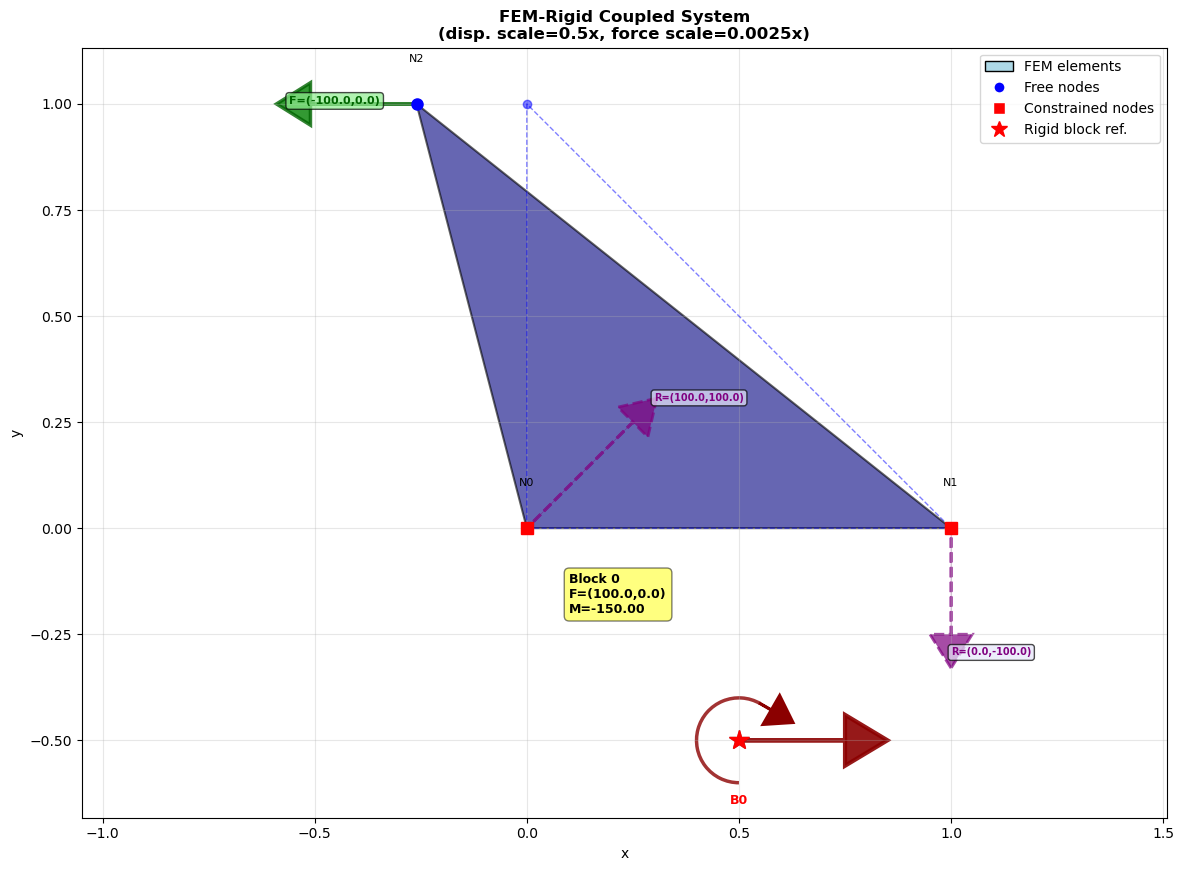

In [35]:
def example_simple_case():
    """Reproduce the original simple case: single triangle on rigid block"""
    print("\n" + "=" * 70)
    print("EXAMPLE 1: SINGLE TRIANGLE ON RIGID BLOCK (Original Problem)")
    print("=" * 70)

    system = GeneralizedCoupledSystem(verbose=True)

    # Add nodes
    n0 = system.add_node([0.0, 0.0])  # Interface
    n1 = system.add_node([1.0, 0.0])  # Interface
    n2 = system.add_node([0, 1.0])  # Free

    # Add FEM element
    system.add_fem_element([n0, n1, n2], E=1000.0, nu=0.3)

    # Add rigid block
    b0 = system.add_rigid_block([0.5, -0.5])
    system.rigid_blocks[b0].set_fixed('all')

    # Connect nodes to block
    system.connect_node_to_block(n0, b0)
    system.connect_node_to_block(n1, b0)

    # Apply forces
    forces = {
        n2: [-100.0, 0]  # Downward force on free node
    }

    # Solve
    solution = system.solve(forces)

    # Visualize
    fig, ax = plot_mesh_and_solution(system, solution, external_forces=forces,
                                     scale=.5, force_scale=0.0025)
    fig.savefig('out/demo_single_triangle.png', dpi=150, bbox_inches='tight')
    print("\nSaved: demo_single_triangle.png")

    return system, solution


print("\nRunning Example 1: Single Triangle (Original)")
system1, sol1 = example_simple_case()



Running Example 2: Multiple Elements

EXAMPLE 2: MULTIPLE TRIANGULAR ELEMENTS
Added FEM element 0 with nodes [0, 1, 3]
Added FEM element 1 with nodes [1, 4, 3]
Added FEM element 2 with nodes [1, 2, 4]
Added FEM element 3 with nodes [2, 5, 4]
Added rigid block 0 at [1.0, -0.5]
Connected node 0 to rigid block 0
Connected node 1 to rigid block 0
Connected node 2 to rigid block 0

SOLVING COUPLED SYSTEM

DOF mapping built:
  Free nodes: 3 (6 DOFs)
  Constrained nodes: 3
  Rigid blocks: 1 (3 DOFs)
  Total DOFs: 9

Global stiffness matrix assembled: (9, 9)
  Non-zero entries: 61

Boundary conditions:
  Fixed DOFs: 3
  Free DOFs: 6

Reduced system size: 6 x 6
Condition number: 1.20e+01

SOLUTION
Node 0 (constrained): u=  0.0000, v=  0.0000
Node 1 (constrained): u=  0.0000, v=  0.0000
Node 2 (constrained): u=  0.0000, v=  0.0000
Node 3: u=  0.0569, v= -0.0101
Node 4: u= -0.0034, v= -0.0357
Node 5: u= -0.0968, v=  0.0366
Block 0: u=  0.0000, v=  0.0000, θ=  0.0000

REACTIONS
Block 0 (fixed): 

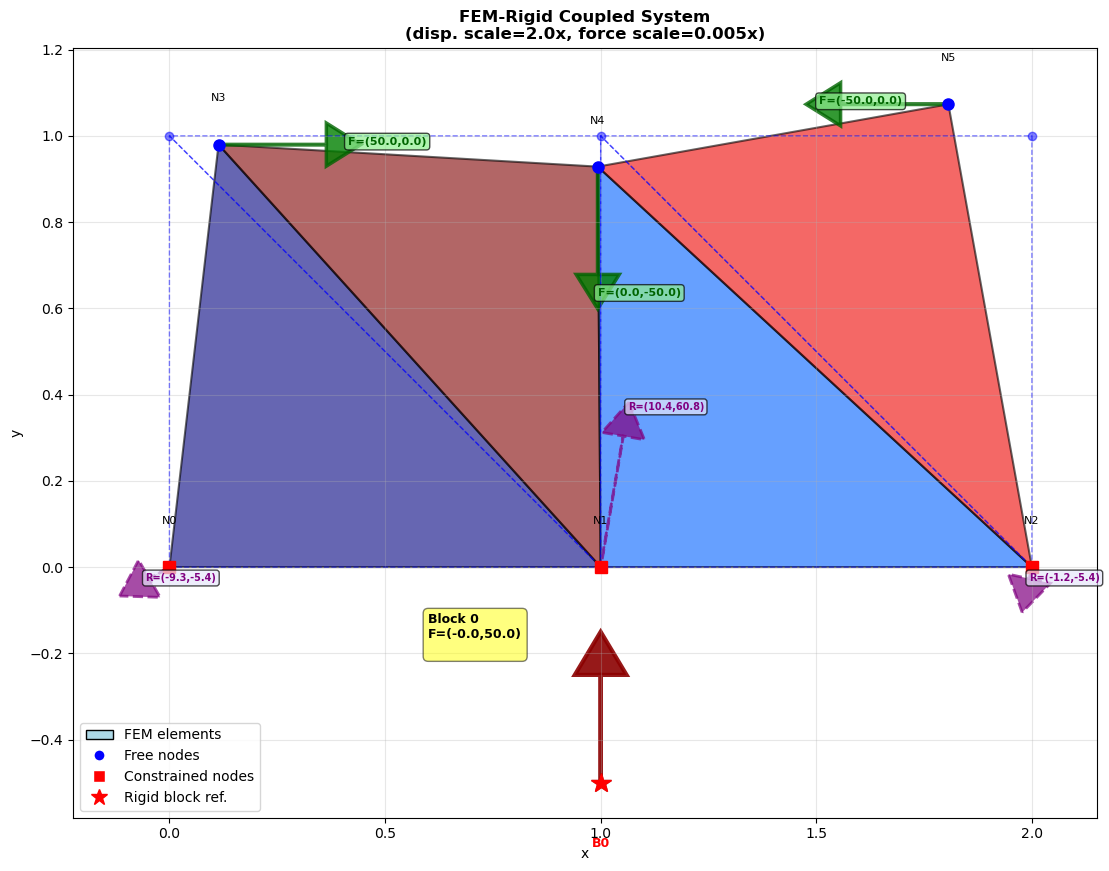

In [29]:
def example_multiple_elements():
    """Example with multiple triangular elements forming a mesh"""
    print("\n" + "=" * 70)
    print("EXAMPLE 2: MULTIPLE TRIANGULAR ELEMENTS")
    print("=" * 70)

    system = GeneralizedCoupledSystem(verbose=True)

    # Create a mesh of 4 triangles
    # Node layout:
    #   3 --- 4 --- 5
    #   | \ 2| \ 3|
    #   |  \ |  \ |
    #   | 0 \| 1 \|
    #   0 --- 1 --- 2

    # Add nodes
    n0 = system.add_node([0.0, 0.0])
    n1 = system.add_node([1.0, 0.0])
    n2 = system.add_node([2.0, 0.0])
    n3 = system.add_node([0.0, 1.0])
    n4 = system.add_node([1.0, 1.0])
    n5 = system.add_node([2.0, 1.0])

    # Add FEM elements
    system.add_fem_element([n0, n1, n3], E=1000.0, nu=0.3)  # Element 0
    system.add_fem_element([n1, n4, n3], E=1000.0, nu=0.3)  # Element 1
    system.add_fem_element([n1, n2, n4], E=1000.0, nu=0.3)  # Element 2
    system.add_fem_element([n2, n5, n4], E=1000.0, nu=0.3)  # Element 3

    # Add rigid block at bottom
    b0 = system.add_rigid_block([1.0, -0.5])
    system.rigid_blocks[b0].set_fixed('all')

    # Connect bottom nodes to rigid block
    system.connect_node_to_block(n0, b0)
    system.connect_node_to_block(n1, b0)
    system.connect_node_to_block(n2, b0)

    # Apply forces on top nodes
    forces = {
        n3: [50.0, 0.0],
        n4: [0.0, -50.0],
        n5: [-50.0, 0.0]
    }

    # Solve
    solution = system.solve(forces)

    # Visualize
    fig, ax = plot_mesh_and_solution(system, solution, external_forces=forces,
                                     scale=2.0, force_scale=0.005)
    plt.savefig('out/demo_multiple_elements.png', dpi=150, bbox_inches='tight')
    print("\nSaved: demo_multiple_elements.png")

    return system, solution


print("\n\nRunning Example 2: Multiple Elements")
system2, sol2 = example_multiple_elements()



Running Example 3: Multiple Rigid Blocks

EXAMPLE 3: MULTIPLE RIGID BLOCKS
Added FEM element 0 with nodes [0, 1, 2]
Added FEM element 1 with nodes [1, 3, 2]
Added FEM element 2 with nodes [2, 3, 4]
Added FEM element 3 with nodes [3, 5, 4]
Added rigid block 0 at [0.5, -0.5]
Added rigid block 1 at [0.5, 2.5]
Connected node 0 to rigid block 0
Connected node 1 to rigid block 0
Connected node 4 to rigid block 1
Connected node 5 to rigid block 1

SOLVING COUPLED SYSTEM

DOF mapping built:
  Free nodes: 2 (4 DOFs)
  Constrained nodes: 4
  Rigid blocks: 2 (6 DOFs)
  Total DOFs: 10

Global stiffness matrix assembled: (10, 10)
  Non-zero entries: 75

Boundary conditions:
  Fixed DOFs: 3
  Free DOFs: 7

Reduced system size: 7 x 7
Condition number: 8.27e+01

SOLUTION
Node 0 (constrained): u=  0.0000, v=  0.0000
Node 1 (constrained): u=  0.0000, v=  0.0000
Node 2: u=  0.1576, v=  0.0176
Node 3: u=  0.1849, v= -0.1168
Node 4 (constrained): u=  0.2991, v=  0.0070
Node 5 (constrained): u=  0.2991, v

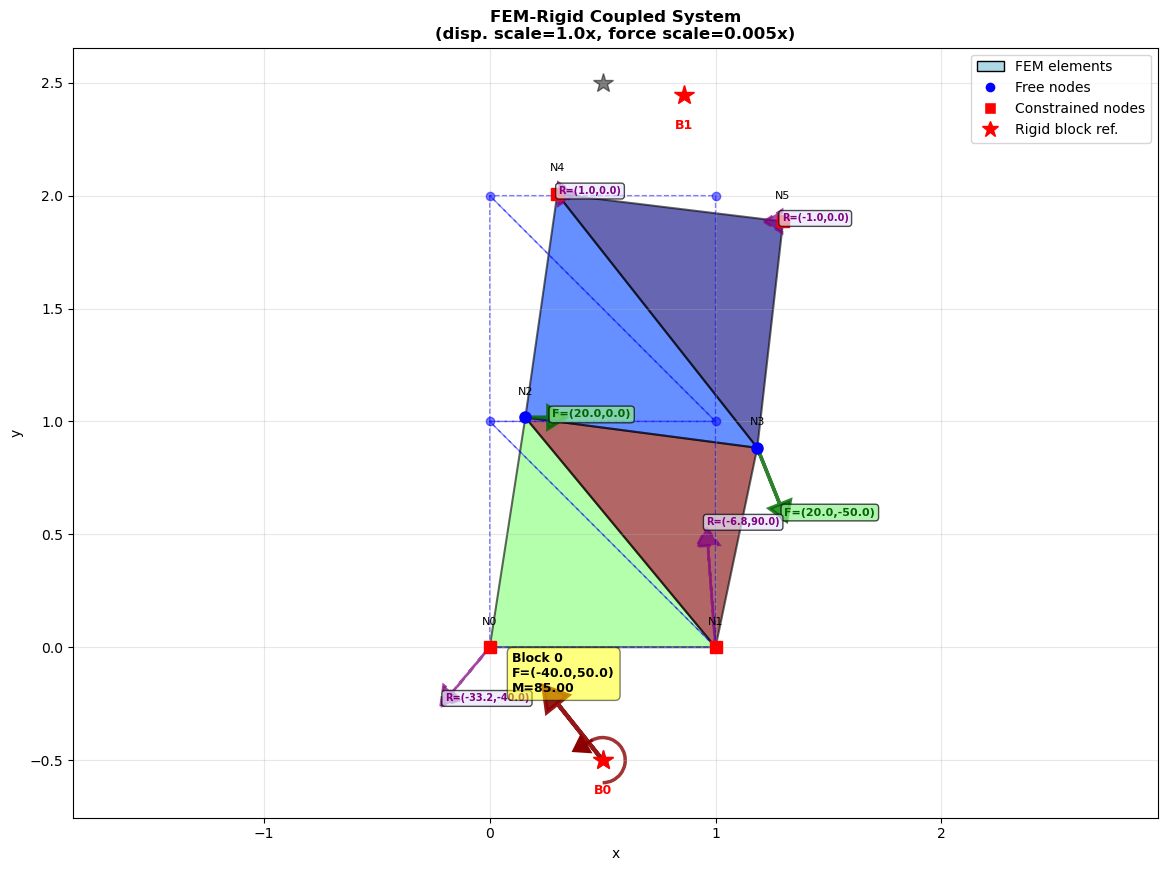

In [30]:
def example_two_blocks():
    """Example with multiple rigid blocks"""
    print("\n" + "=" * 70)
    print("EXAMPLE 3: MULTIPLE RIGID BLOCKS")
    print("=" * 70)

    system = GeneralizedCoupledSystem(verbose=True)

    # Create two rigid blocks connected by FEM elements
    # Block 0 (bottom, fixed) -- FEM -- Block 1 (top, free)

    # Bottom block nodes
    n0 = system.add_node([0.0, 0.0])
    n1 = system.add_node([1.0, 0.0])

    # Middle nodes (free)
    n2 = system.add_node([0.0, 1.0])
    n3 = system.add_node([1.0, 1.0])

    # Top block nodes
    n4 = system.add_node([0.0, 2.0])
    n5 = system.add_node([1.0, 2.0])

    # Add FEM elements
    system.add_fem_element([n0, n1, n2], E=1000.0, nu=0.3)
    system.add_fem_element([n1, n3, n2], E=1000.0, nu=0.3)
    system.add_fem_element([n2, n3, n4], E=1000.0, nu=0.3)
    system.add_fem_element([n3, n5, n4], E=1000.0, nu=0.3)

    # Add rigid blocks
    b0 = system.add_rigid_block([0.5, -0.5], name="Bottom")
    system.rigid_blocks[b0].set_fixed('all')

    b1 = system.add_rigid_block([0.5, 2.5], name="Top")
    system.rigid_blocks[b1].set_fixed([])  # Completely free

    # Connect nodes to blocks
    system.connect_node_to_block(n0, b0)
    system.connect_node_to_block(n1, b0)
    system.connect_node_to_block(n4, b1)
    system.connect_node_to_block(n5, b1)

    # Apply forces
    forces = {
        n2: [20.0, 0.0],
        n3: [20.0, -50.0]
    }

    # Solve
    solution = system.solve(forces)

    # Visualize
    fig, ax = plot_mesh_and_solution(system, solution, external_forces=forces,
                                     scale=1.0, force_scale=0.005)
    plt.savefig('out/demo_multiple_rigid_blocks.png', dpi=150, bbox_inches='tight')
    print("\nSaved: demo_multiple_rigid_blocks.png")

    return system, solution


print("\n\nRunning Example 3: Multiple Rigid Blocks")
system3, sol3 = example_two_blocks()


DEMO: CANTILEVER WITH FORCE VISUALIZATION
Added FEM element 0 with nodes [0, 1, 4]
Added FEM element 1 with nodes [1, 5, 4]
Added FEM element 2 with nodes [1, 2, 5]
Added FEM element 3 with nodes [2, 6, 5]
Added FEM element 4 with nodes [2, 3, 6]
Added FEM element 5 with nodes [3, 7, 6]
Added rigid block 0 at [-0.25, 0.25]
Connected node 0 to rigid block 0
Connected node 4 to rigid block 0

SOLVING COUPLED SYSTEM

DOF mapping built:
  Free nodes: 6 (12 DOFs)
  Constrained nodes: 2
  Rigid blocks: 1 (3 DOFs)
  Total DOFs: 15

Global stiffness matrix assembled: (15, 15)
  Non-zero entries: 115

Boundary conditions:
  Fixed DOFs: 3
  Free DOFs: 12

Reduced system size: 12 x 12
Condition number: 1.72e+03

SOLUTION
Node 0 (constrained): u=  0.0000, v=  0.0000
Node 1: u= -0.5840, v= -1.6617
Node 2: u= -0.8972, v= -5.3768
Node 3: u= -0.9678, v=-10.1231
Node 4 (constrained): u=  0.0000, v=  0.0000
Node 5: u=  0.6864, v= -1.7110
Node 6: u=  1.1315, v= -5.4261
Node 7: u=  1.3314, v=-10.1678
Blo

(<__main__.GeneralizedCoupledSystem at 0x2381fb6e600>,
 {'node_displacements': {1: array([-0.58399502, -1.6617214 ]),
   2: array([-0.89717301, -5.37681186]),
   3: array([ -0.96780764, -10.12306357]),
   5: array([ 0.68638317, -1.71103498]),
   6: array([ 1.13154821, -5.42614335]),
   7: array([  1.33143393, -10.16781724]),
   0: array([0., 0.]),
   4: array([0., 0.])},
  'block_displacements': {0: array([0., 0., 0.])},
  'u_global': array([ -0.58399502,  -1.6617214 ,  -0.89717301,  -5.37681186,
          -0.96780764, -10.12306357,   0.68638317,  -1.71103498,
           1.13154821,  -5.42614335,   1.33143393, -10.16781724,
           0.        ,   0.        ,   0.        ]),
  'reactions': {'block_reactions': {0: array([-20.,  80., 265.])},
   'F_internal': array([ 2.27373675e-13,  9.09494702e-13,  4.54747351e-13,  0.00000000e+00,
           0.00000000e+00, -5.00000000e+01, -5.68434189e-13, -5.68434189e-13,
          -6.82121026e-13,  2.50111043e-12,  2.00000000e+01, -3.00000000e+01,


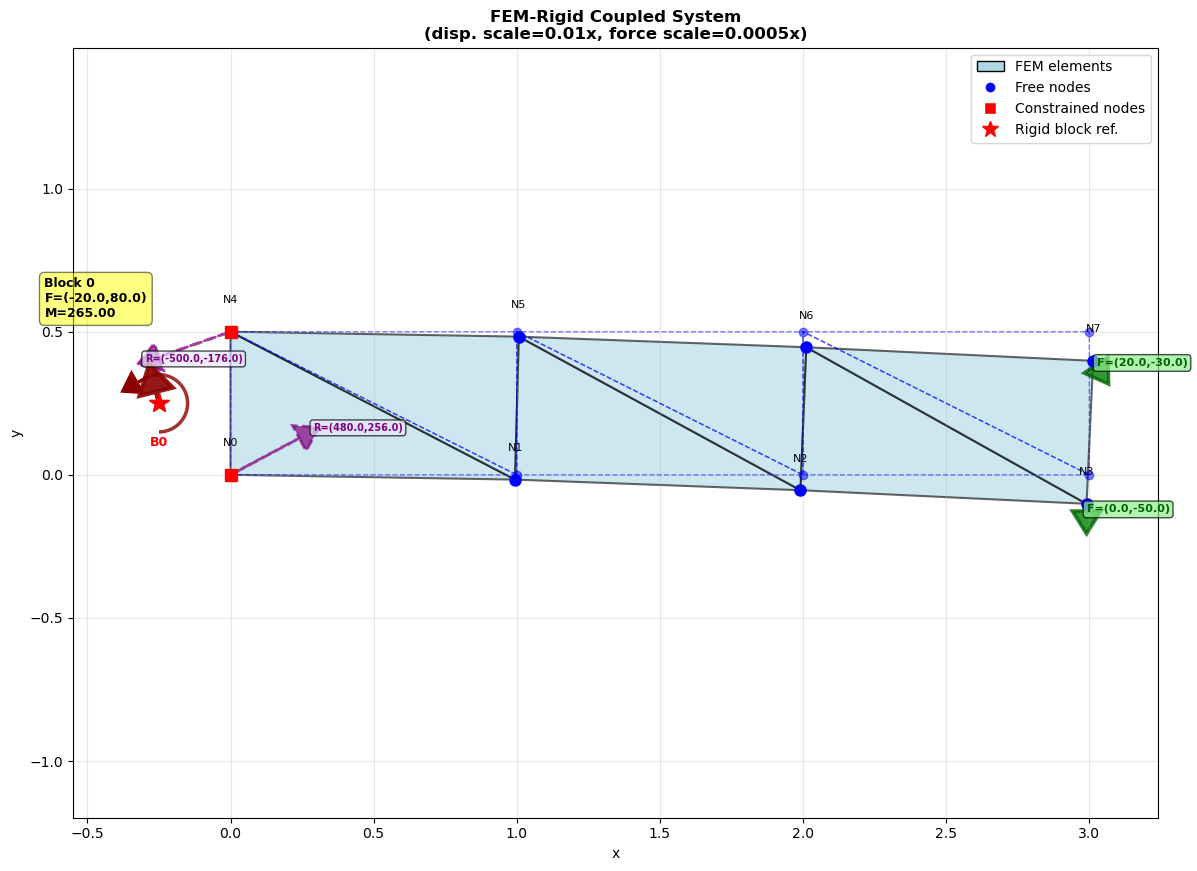

In [31]:
"""
Demonstration of force visualization capabilities in the generalized FEM-Rigid system
Shows: external forces, reaction forces, and moments at rigid blocks
"""
import matplotlib.pyplot as plt


def demo_cantilever_with_forces():
    """
    Cantilever beam example showing:
    - External forces (green arrows)
    - Reaction forces at constrained nodes (purple arrows)
    - Resultant force and moment on rigid block (red arrows + arc)
    """
    print("\n" + "=" * 70)
    print("DEMO: CANTILEVER WITH FORCE VISUALIZATION")
    print("=" * 70)

    system = GeneralizedCoupledSystem(verbose=True)

    # Create cantilever: fixed at left, free at right
    # 3 elements in series
    n0 = system.add_node([0.0, 0.0])
    n1 = system.add_node([1.0, 0.0])
    n2 = system.add_node([2.0, 0.0])
    n3 = system.add_node([3.0, 0.0])
    n4 = system.add_node([0.0, 0.5])
    n5 = system.add_node([1.0, 0.5])
    n6 = system.add_node([2.0, 0.5])
    n7 = system.add_node([3.0, 0.5])

    # Add elements
    system.add_fem_element([n0, n1, n4], E=1000.0, nu=0.3)
    system.add_fem_element([n1, n5, n4], E=1000.0, nu=0.3)
    system.add_fem_element([n1, n2, n5], E=1000.0, nu=0.3)
    system.add_fem_element([n2, n6, n5], E=1000.0, nu=0.3)
    system.add_fem_element([n2, n3, n6], E=1000.0, nu=0.3)
    system.add_fem_element([n3, n7, n6], E=1000.0, nu=0.3)

    # Fixed support at left
    b0 = system.add_rigid_block([-0.25, 0.25], name="Fixed Support")
    system.rigid_blocks[b0].set_fixed('all')
    system.connect_node_to_block(n0, b0)
    system.connect_node_to_block(n4, b0)

    # Apply forces at free end
    forces = {
        n3: [0.0, -50.0],  # Downward force
        n7: [20.0, -30.0]  # Angled force
    }

    # Solve
    solution = system.solve(forces)

    # Visualize with forces
    fig, ax = plot_mesh_and_solution(
        system, solution,
        external_forces=forces,
        scale=0.01,
        force_scale=0.0005,
        show_stress=False
    )

    plt.savefig('out/demo_cantilever_forces.png', dpi=150, bbox_inches='tight')
    print("\nSaved: demo_cantilever_forces.png")

    return system, solution


demo_cantilever_with_forces()



DEMO: SYMMETRIC LOADING
Added FEM element 0 with nodes [0, 1, 2]
Added FEM element 1 with nodes [1, 3, 2]
Added FEM element 2 with nodes [2, 3, 4]
Added rigid block 0 at [1.0, -0.5]
Connected node 0 to rigid block 0
Connected node 1 to rigid block 0

SOLVING COUPLED SYSTEM

DOF mapping built:
  Free nodes: 3 (6 DOFs)
  Constrained nodes: 2
  Rigid blocks: 1 (3 DOFs)
  Total DOFs: 9

Global stiffness matrix assembled: (9, 9)
  Non-zero entries: 63

Boundary conditions:
  Fixed DOFs: 3
  Free DOFs: 6

Reduced system size: 6 x 6
Condition number: 1.99e+01

SOLUTION
Node 0 (constrained): u=  0.0000, v=  0.0000
Node 1 (constrained): u=  0.0000, v=  0.0000
Node 2: u=  0.0145, v= -0.0480
Node 3: u= -0.0197, v= -0.0378
Node 4: u= -0.0051, v= -0.0677
Block 0: u=  0.0000, v=  0.0000, θ=  0.0000

REACTIONS
Block 0 (fixed): Fx=  0.0000, Fy=100.0000, M=  0.0000

Element 0:
  Stress: σxx=-15.8391, σyy=-52.7971, τxy=5.5943
  Strain: εxx=0.000000, εyy=-0.048045, γxy=0.014545

Element 1:
  Stress: σxx

(<__main__.GeneralizedCoupledSystem at 0x23821c14e30>,
 {'node_displacements': {2: array([ 0.01454515, -0.0480454 ]),
   3: array([-0.01965561, -0.03782449]),
   4: array([-0.00511046, -0.06766989]),
   0: array([0., 0.]),
   1: array([0., 0.])},
  'block_displacements': {0: array([0., 0., 0.])},
  'u_global': array([ 0.01454515, -0.0480454 , -0.01965561, -0.03782449, -0.00511046,
         -0.06766989,  0.        ,  0.        ,  0.        ]),
  'reactions': {'block_reactions': {0: array([  0., 100.,   0.])},
   'F_internal': array([ 3.0000000e+01, -2.0000000e+01, -3.0000000e+01, -2.0000000e+01,
          -4.4408921e-16, -6.0000000e+01,  0.0000000e+00,  1.0000000e+02,
           0.0000000e+00]),
   'reactions_global': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.42108547e-14,
          -4.44089210e-16,  1.42108547e-14,  0.00000000e+00,  1.00000000e+02,
           0.00000000e+00])}})

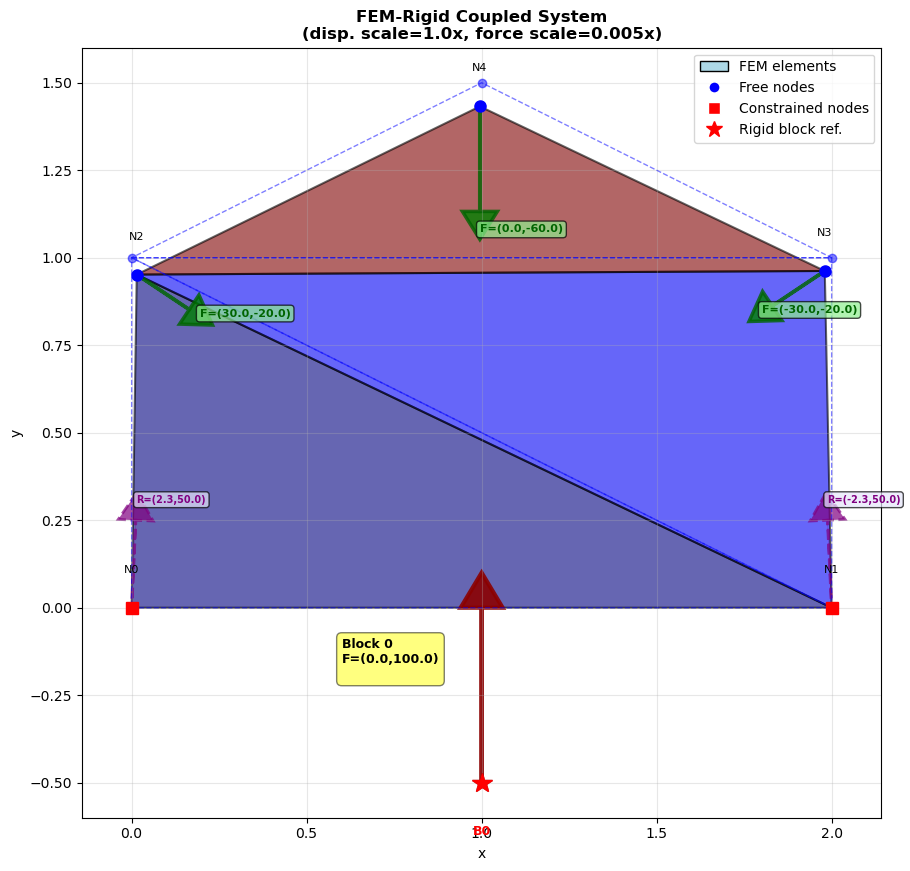

In [32]:
def demo_symmetric_loading():
    """
    Symmetric structure with symmetric loading
    Shows force balance
    """
    print("\n" + "=" * 70)
    print("DEMO: SYMMETRIC LOADING")
    print("=" * 70)

    system = GeneralizedCoupledSystem(verbose=True)

    # Create more stable structure with better connectivity
    n0 = system.add_node([0.0, 0.0])  # Bottom left
    n1 = system.add_node([2.0, 0.0])  # Bottom right
    n2 = system.add_node([0.0, 1.0])  # Mid left
    n3 = system.add_node([2.0, 1.0])  # Mid right
    n4 = system.add_node([1.0, 1.5])  # Top center

    # Add elements - create stable triangulation
    system.add_fem_element([n0, n1, n2], E=1000.0, nu=0.3)
    system.add_fem_element([n1, n3, n2], E=1000.0, nu=0.3)
    system.add_fem_element([n2, n3, n4], E=1000.0, nu=0.3)

    # Fixed at bottom
    b0 = system.add_rigid_block([1.0, -0.5])
    system.rigid_blocks[b0].set_fixed('all')
    system.connect_node_to_block(n0, b0)
    system.connect_node_to_block(n1, b0)

    # Symmetric forces
    forces = {
        n2: [30.0, -20.0],
        n3: [-30.0, -20.0],
        n4: [0.0, -60.0]
    }

    solution = system.solve(forces)

    fig, ax = plot_mesh_and_solution(
        system, solution,
        external_forces=forces,
        scale=1.0,
        force_scale=0.005,
        show_stress=True
    )

    plt.savefig('out/demo_symmetric_forces.png', dpi=150, bbox_inches='tight')
    print("\nSaved: demo_symmetric_forces.png")

    return system, solution


demo_symmetric_loading()


DEMO: MOMENT GENERATION ON BLOCK
Added FEM element 0 with nodes [0, 1, 2]
Added FEM element 1 with nodes [1, 3, 2]
Added FEM element 2 with nodes [2, 5, 4]
Added FEM element 3 with nodes [2, 3, 5]
Added rigid block 0 at [0.5, -0.5]
Connected node 0 to rigid block 0
Connected node 1 to rigid block 0

SOLVING COUPLED SYSTEM

DOF mapping built:
  Free nodes: 4 (8 DOFs)
  Constrained nodes: 2
  Rigid blocks: 1 (3 DOFs)
  Total DOFs: 11

Global stiffness matrix assembled: (11, 11)
  Non-zero entries: 79

Boundary conditions:
  Fixed DOFs: 3
  Free DOFs: 8

Reduced system size: 8 x 8
Condition number: 1.49e+02

SOLUTION
Node 0 (constrained): u=  0.0000, v=  0.0000
Node 1 (constrained): u=  0.0000, v=  0.0000
Node 2: u=  0.5339, v=  0.1359
Node 3: u=  0.6295, v= -0.7197
Node 4: u=  1.9716, v=  0.8715
Node 5: u=  1.8099, v= -0.4420
Block 0: u=  0.0000, v=  0.0000, θ=  0.0000

REACTIONS
Block 0 (fixed): Fx=-50.0000, Fy= 70.0000, M=200.0000

Element 0:
  Stress: σxx=44.7905, σyy=149.3018, τxy=2

(<__main__.GeneralizedCoupledSystem at 0x23820bffe30>,
 {'node_displacements': {2: array([0.53390765, 0.13586465]),
   3: array([ 0.62947463, -0.71973414]),
   4: array([1.97156788, 0.8714564 ]),
   5: array([ 1.809899  , -0.44197848]),
   0: array([0., 0.]),
   1: array([0., 0.])},
  'block_displacements': {0: array([0., 0., 0.])},
  'u_global': array([ 0.53390765,  0.13586465,  0.62947463, -0.71973414,  1.97156788,
          0.8714564 ,  1.809899  , -0.44197848,  0.        ,  0.        ,
          0.        ]),
  'reactions': {'block_reactions': {0: array([-50.,  70., 200.])},
   'F_internal': array([ 1.13686838e-13,  8.52651283e-14, -3.00000000e+01, -2.00000000e+01,
           8.00000000e+01, -6.03961325e-14,  4.12114787e-13, -5.00000000e+01,
          -5.00000000e+01,  7.00000000e+01,  2.00000000e+02]),
   'reactions_global': array([ 1.13686838e-13,  8.52651283e-14,  1.84741111e-13,  4.26325641e-14,
           5.68434189e-14, -6.03961325e-14,  4.12114787e-13,  0.00000000e+00,
     

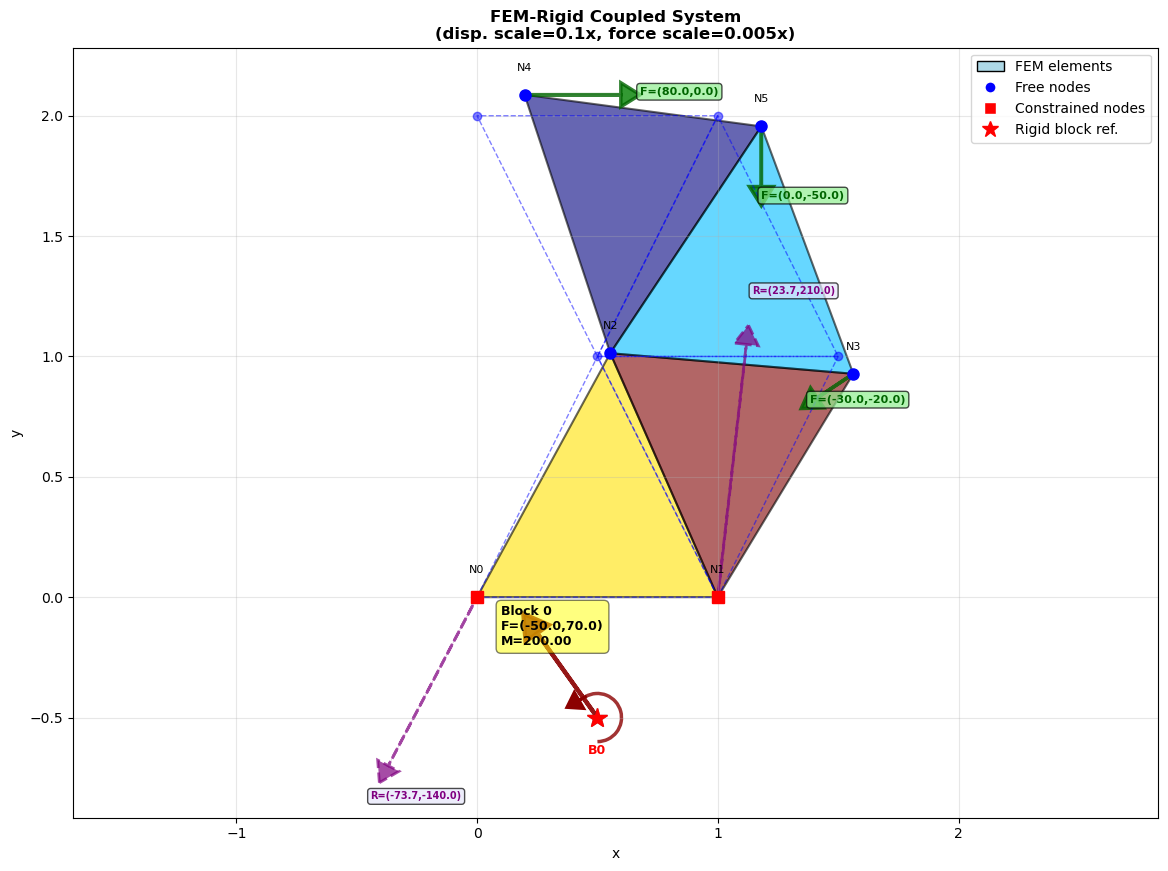

In [33]:
def demo_moment_on_block():
    """
    Structure creating significant moment on rigid block
    """
    print("\n" + "=" * 70)
    print("DEMO: MOMENT GENERATION ON BLOCK")
    print("=" * 70)

    system = GeneralizedCoupledSystem(verbose=True)

    # Create T-shaped structure
    n0 = system.add_node([0.0, 0.0])
    n1 = system.add_node([1.0, 0.0])
    n2 = system.add_node([0.5, 1.0])
    n3 = system.add_node([1.5, 1.0])
    n4 = system.add_node([0.0, 2.0])
    n5 = system.add_node([1.0, 2.0])

    # Add elements
    system.add_fem_element([n0, n1, n2], E=1000.0, nu=0.3)
    system.add_fem_element([n1, n3, n2], E=1000.0, nu=0.3)
    system.add_fem_element([n2, n5, n4], E=1000.0, nu=0.3)
    system.add_fem_element([n2, n3, n5], E=1000.0, nu=0.3)

    # Fixed at bottom
    b0 = system.add_rigid_block([0.5, -0.5])
    system.rigid_blocks[b0].set_fixed('all')
    system.connect_node_to_block(n0, b0)
    system.connect_node_to_block(n1, b0)

    # Asymmetric loading to create moment
    forces = {
        n4: [80.0, 0.0],  # Strong horizontal at left
        n5: [0.0, -50.0],  # Downward at center
        n3: [-30.0, -20.0]  # Angled at right
    }

    solution = system.solve(forces)

    fig, ax = plot_mesh_and_solution(
        system, solution,
        external_forces=forces,
        scale=0.1,
        force_scale=0.005,
        show_stress=True
    )

    plt.savefig('out/demo_moment_on_block.png', dpi=150, bbox_inches='tight')
    print("\nSaved: demo_moment_on_block.png")

    # Print detailed force analysis
    print("\n" + "=" * 70)
    print("FORCE ANALYSIS")
    print("=" * 70)

    reactions = solution['reactions']
    block_reaction = reactions['block_reactions'][0]

    print(f"\nExternal Forces Applied:")
    total_ext_force = np.zeros(2)
    total_ext_moment = 0.0
    for nid, force in forces.items():
        pos = system.node_positions[nid]
        print(f"  Node {nid} at ({pos[0]:.1f}, {pos[1]:.1f}): F=({force[0]:.1f}, {force[1]:.1f})")
        total_ext_force += force
        # Moment about block reference
        r = pos - system.rigid_blocks[0].ref_point
        total_ext_moment += r[0] * force[1] - r[1] * force[0]

    print(f"\nTotal External Force: ({total_ext_force[0]:.1f}, {total_ext_force[1]:.1f})")
    print(f"Total External Moment about block ref: {total_ext_moment:.2f}")

    print(f"\nBlock Reaction:")
    print(f"  Force: ({block_reaction[0]:.1f}, {block_reaction[1]:.1f})")
    print(f"  Moment: {block_reaction[2]:.2f}")

    print(f"\nEquilibrium Check:")
    print(
        f"  Force balance: ({total_ext_force[0] + block_reaction[0]:.2e}, {total_ext_force[1] + block_reaction[1]:.2e})")
    print(f"  Moment balance: {total_ext_moment + block_reaction[2]:.2e}")

    return system, solution


demo_moment_on_block()

# Geometry

In [34]:
# -*- coding: utf-8 -*-
"""
Geometric Properties Helper Module

Provides shared geometric calculations for both Block_2D and FE elements.
Implements lazy evaluation and caching for efficient property computation.

"""

import numpy as np
from typing import Optional, Tuple
from dataclasses import dataclass, field


@dataclass
class PolygonProperties:
    """
    Computes and caches geometric properties of a 2D polygon.

    Uses lazy evaluation: properties are only computed when first accessed,
    then cached for subsequent access.

    Attributes:
        vertices: (N, 2) array of polygon vertices in CCW order
        rho: Material density [kg/m³]
        thickness: Out-of-plane thickness [m] (b parameter)
        ref_point: Reference point for moment of inertia calculation
                   If None, uses centroid
    """
    vertices: np.ndarray
    rho: float
    thickness: float = 1.0
    ref_point: Optional[np.ndarray] = None

    # Cached values (computed lazily)
    _area: Optional[float] = field(default=None, init=False, repr=False)
    _centroid: Optional[np.ndarray] = field(default=None, init=False, repr=False)
    _mass: Optional[float] = field(default=None, init=False, repr=False)
    _moment_of_inertia: Optional[float] = field(default=None, init=False, repr=False)
    _bounding_circle: Optional[Tuple[np.ndarray, float]] = field(default=None, init=False, repr=False)

    def __post_init__(self):
        """Validate inputs and ensure vertices are numpy array."""
        self.vertices = np.asarray(self.vertices, dtype=float)
        if self.vertices.ndim != 2 or self.vertices.shape[1] != 2:
            raise ValueError("vertices must be (N, 2) array")
        if len(self.vertices) < 3:
            raise ValueError("Polygon must have at least 3 vertices")
        if self.rho <= 0:
            raise ValueError("Density must be positive")
        if self.thickness <= 0:
            raise ValueError("Thickness must be positive")

    def invalidate_cache(self):
        """Clear all cached values (call if vertices are modified)."""
        self._area = None
        self._centroid = None
        self._mass = None
        self._moment_of_inertia = None
        self._bounding_circle = None

    @property
    def area(self) -> float:
        """
        Compute signed area of polygon using shoelace formula.

        Returns positive area for CCW vertices, negative for CW.
        """
        if self._area is None:
            v = self.vertices
            n = len(v)
            # Vectorized shoelace formula
            self._area = 0.5 * np.abs(
                np.sum(v[:, 0] * np.roll(v[:, 1], -1) -
                       np.roll(v[:, 0], -1) * v[:, 1])
            )
        return self._area

    @property
    def centroid(self) -> np.ndarray:
        """
        Compute centroid (center of mass) of polygon.

        Returns:
            (2,) array: [x_c, y_c] centroid coordinates
        """
        if self._centroid is None:
            v = self.vertices
            n = len(v)
            A = self.area

            # Shoelace terms
            cross_terms = (v[:, 0] * np.roll(v[:, 1], -1) -
                           np.roll(v[:, 0], -1) * v[:, 1])

            cx = np.sum((v[:, 0] + np.roll(v[:, 0], -1)) * cross_terms) / (6 * A)
            cy = np.sum((v[:, 1] + np.roll(v[:, 1], -1)) * cross_terms) / (6 * A)

            self._centroid = np.array([cx, cy])
        return self._centroid

    @property
    def mass(self) -> float:
        """Compute total mass: m = rho * A * thickness"""
        if self._mass is None:
            self._mass = self.rho * self.area * self.thickness
        return self._mass

    @property
    def moment_of_inertia(self) -> float:
        """
        Compute moment of inertia about reference point.

        Uses parallel axis theorem:
        I_ref = I_centroid + m * d²

        where d is distance from centroid to reference point.
        """
        if self._moment_of_inertia is None:
            # Vertices relative to centroid
            v_centered = self.vertices - self.centroid
            n = len(v_centered)

            # Moment of inertia about centroid
            I_c = 0.0
            for i in range(n):
                j = (i + 1) % n
                vi, vj = v_centered[i], v_centered[j]
                cross = vi[0] * vj[1] - vj[0] * vi[1]
                I_c += cross * (
                        vi[0] ** 2 + vi[0] * vj[0] + vj[0] ** 2 +
                        vi[1] ** 2 + vi[1] * vj[1] + vj[1] ** 2
                )
            I_c = self.mass * I_c / (12 * self.area)

            # Apply parallel axis theorem
            ref = self.ref_point if self.ref_point is not None else self.centroid
            d = self.centroid - ref
            self._moment_of_inertia = I_c + self.mass * np.dot(d, d)

        return self._moment_of_inertia

    @property
    def bounding_circle(self) -> Tuple[np.ndarray, float]:
        """
        Compute minimum enclosing circle using Welzl's algorithm.

        Returns:
            tuple: (center, radius) where center is (2,) array
        """
        if self._bounding_circle is None:
            self._bounding_circle = self._welzl_algorithm(self.vertices)
        return self._bounding_circle

    def _welzl_algorithm(self, points: np.ndarray) -> Tuple[np.ndarray, float]:
        """
        Welzl's algorithm for minimum enclosing circle.
        O(n) expected time complexity.
        """

        def distance(a: np.ndarray, b: np.ndarray) -> float:
            return np.linalg.norm(a - b)

        def is_inside(circle_center: np.ndarray, circle_radius: float,
                      point: np.ndarray) -> bool:
            return distance(circle_center, point) <= circle_radius + 1e-10

        def circle_from_2_points(p1: np.ndarray, p2: np.ndarray) -> Tuple[np.ndarray, float]:
            center = (p1 + p2) / 2
            radius = distance(p1, p2) / 2
            return center, radius

        def circle_from_3_points(p1: np.ndarray, p2: np.ndarray,
                                 p3: np.ndarray) -> Tuple[np.ndarray, float]:
            # Compute circumcircle of triangle
            ax, ay = p1
            bx, by = p2
            cx, cy = p3

            D = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
            if abs(D) < 1e-10:
                # Degenerate case: points are collinear
                # Return circle from two furthest points
                d12 = distance(p1, p2)
                d23 = distance(p2, p3)
                d31 = distance(p3, p1)
                if d12 >= d23 and d12 >= d31:
                    return circle_from_2_points(p1, p2)
                elif d23 >= d12 and d23 >= d31:
                    return circle_from_2_points(p2, p3)
                else:
                    return circle_from_2_points(p3, p1)

            ux = ((ax ** 2 + ay ** 2) * (by - cy) +
                  (bx ** 2 + by ** 2) * (cy - ay) +
                  (cx ** 2 + cy ** 2) * (ay - by)) / D
            uy = ((ax ** 2 + ay ** 2) * (cx - bx) +
                  (bx ** 2 + by ** 2) * (ax - cx) +
                  (cx ** 2 + cy ** 2) * (bx - ax)) / D

            center = np.array([ux, uy])
            radius = distance(center, p1)
            return center, radius

        def min_circle_trivial(pts: list) -> Tuple[np.ndarray, float]:
            """Minimum circle for 0, 1, 2, or 3 points."""
            if len(pts) == 0:
                return np.zeros(2), 0.0
            elif len(pts) == 1:
                return pts[0].copy(), 0.0
            elif len(pts) == 2:
                return circle_from_2_points(pts[0], pts[1])
            else:  # len(pts) == 3
                # Try all pairs first
                for i in range(3):
                    for j in range(i + 1, 3):
                        c, r = circle_from_2_points(pts[i], pts[j])
                        if all(is_inside(c, r, pts[k]) for k in range(3)):
                            return c, r
                # All three points needed
                return circle_from_3_points(pts[0], pts[1], pts[2])

        def welzl_recursive(P: list, R: list) -> Tuple[np.ndarray, float]:
            """Recursive Welzl algorithm."""
            if len(P) == 0 or len(R) == 3:
                return min_circle_trivial(R)

            # Pick random point (last in list for simplicity)
            p = P[-1]
            P_without_p = P[:-1]

            # Recurse without p
            c, r = welzl_recursive(P_without_p, R)

            # If p is inside, we're done
            if is_inside(c, r, p):
                return c, r

            # Otherwise, p must be on the boundary
            return welzl_recursive(P_without_p, R + [p])

        # Convert to list for recursion
        point_list = [points[i] for i in range(len(points))]
        return welzl_recursive(point_list, [])


@dataclass
class BeamProperties:
    """
    Geometric properties for beam/Timoshenko elements.

    Attributes:
        length: Beam length [m]
        height: Cross-section height [m]
        thickness: Cross-section thickness/width [m]
        rho: Material density [kg/m³]
    """
    length: float
    height: float
    thickness: float = 1.0
    rho: float = 2500.0

    # Cached values
    _area: Optional[float] = field(default=None, init=False, repr=False)
    _moment_of_inertia: Optional[float] = field(default=None, init=False, repr=False)
    _mass: Optional[float] = field(default=None, init=False, repr=False)

    def __post_init__(self):
        """Validate inputs."""
        if self.length <= 0:
            raise ValueError("Length must be positive")
        if self.height <= 0:
            raise ValueError("Height must be positive")
        if self.thickness <= 0:
            raise ValueError("Thickness must be positive")
        if self.rho <= 0:
            raise ValueError("Density must be positive")

    @property
    def area(self) -> float:
        """Cross-sectional area."""
        if self._area is None:
            self._area = self.height * self.thickness
        return self._area

    @property
    def moment_of_inertia(self) -> float:
        """Second moment of area about neutral axis."""
        if self._moment_of_inertia is None:
            self._moment_of_inertia = (self.thickness * self.height ** 3) / 12
        return self._moment_of_inertia

    @property
    def mass(self) -> float:
        """Total mass of beam element."""
        if self._mass is None:
            self._mass = self.rho * self.area * self.length
        return self._mass

    @property
    def mass_per_length(self) -> float:
        """Linear mass density [kg/m]."""
        return self.rho * self.area


def compute_polygon_area(vertices: np.ndarray) -> float:
    """
    Standalone function to compute polygon area (shoelace formula).

    Args:
        vertices: (N, 2) array of polygon vertices

    Returns:
        Signed area (positive for CCW, negative for CW)
    """
    v = np.asarray(vertices, dtype=float)
    return 0.5 * np.sum(
        v[:, 0] * np.roll(v[:, 1], -1) -
        np.roll(v[:, 0], -1) * v[:, 1]
    )


def compute_polygon_centroid(vertices: np.ndarray) -> np.ndarray:
    """
    Standalone function to compute polygon centroid.

    Args:
        vertices: (N, 2) array of polygon vertices

    Returns:
        (2,) array: [x_c, y_c] centroid coordinates
    """
    v = np.asarray(vertices, dtype=float)
    A = compute_polygon_area(v)

    cross_terms = (v[:, 0] * np.roll(v[:, 1], -1) -
                   np.roll(v[:, 0], -1) * v[:, 1])

    cx = np.sum((v[:, 0] + np.roll(v[:, 0], -1)) * cross_terms) / (6 * A)
    cy = np.sum((v[:, 1] + np.roll(v[:, 1], -1)) * cross_terms) / (6 * A)

    return np.array([cx, cy])

## Tests geometry